In [1]:
#import BALTIC: repo needs to be cloned in if you don't have it yet.
import imp
bt = imp.load_source('baltic', '../baltic/baltic/baltic.py')

In [60]:
#import necessary libraries
import re
import copy
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib.lines as mlines
%matplotlib inline

In [6]:
from datetime import datetime as dt
from datetime import timedelta

def decimalDate(date,date_format="%Y-%m-%d"):
    """ Converts calendar dates in specified format to decimal date. """
    sampling_date = dt.strptime(date,date_format)
    year =  sampling_date.year
    beginning_of_year = datetime.datetime(year,1,1) #year, month, day, so year 1,1 == beginning of year
    end_of_year = datetime.datetime(year+1,1,1) #next year 1,1 is a full year away from beginning of sampling year
    #return fraction of the full year (in seconds) that occurs between jan 1st and your sampling date
    return year + ((sampling_date - beginning_of_year).total_seconds() / ((end_of_year - beginning_of_year).total_seconds()))

#Need to make a function to go from decimal date (x's on axis) to 
def decimalDateToAxisLabel(decimalDate):
    """ Converts decimal dates to a word format to date labeling more interpretable """
    year = int(decimalDate)
    dt_format_year = datetime.datetime(year, 1, 1)
    remainder = decimalDate - year
    calendar_date = dt_format_year + timedelta(seconds=(dt_format_year.replace(year=dt_format_year.year + 1) - dt_format_year).total_seconds() * remainder)
    if dt.strftime(calendar_date,"%m" ) == '01':
        label = dt.strftime(calendar_date,"%b\n%Y" )
    else:
        label = dt.strftime(calendar_date,"%b" )
    return label

In [3]:
input_tree_path = "../beast/phylogeography/dec18-test-mcc-medianHeights.tree"

In [4]:
tree = bt.loadNexus(input_tree_path, absoluteTime=False)#absolute time set as False to allow tree read in with deciaml dates
tree.sortBranches(descending=False)

In [57]:
#read in colors from config file, need these for plotting.
country_colors = {}
division_colors = {}

for line in open("../config/colors.tsv", "r"):
    if line.startswith("country"):
        country = line.split("\t")[1]
        hex_color = line.split("\t")[2].rstrip()
        country_colors[country] = hex_color
    elif line.startswith("division"):
        division = line.split("\t")[1]
        hex_color = line.split("\t")[2].rstrip()
        division_colors[division] = hex_color


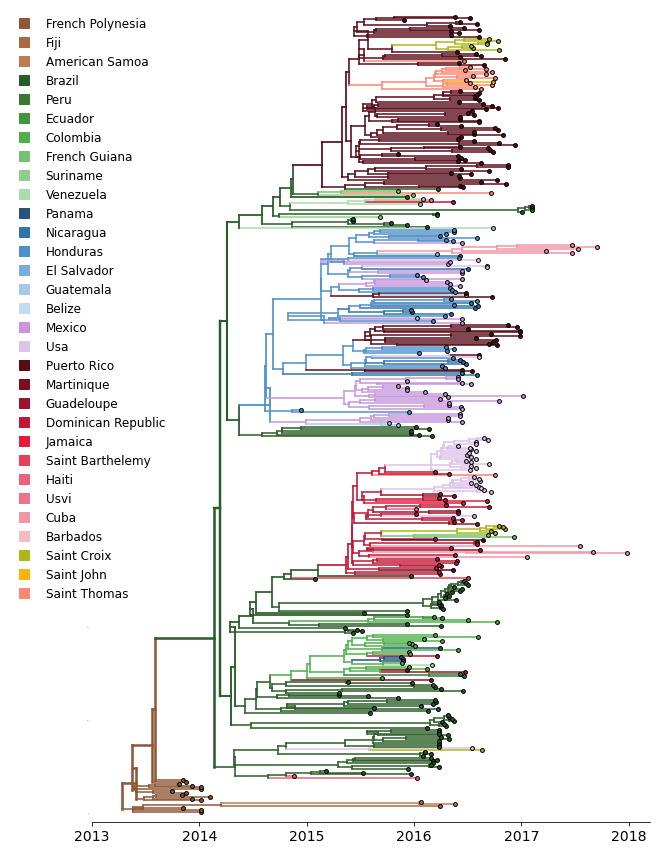

In [98]:
fig,ax = plt.subplots(figsize=(10,15),facecolor='w')
branchWidth=1.5 ## default branch width
tipSize = 15
s=15

root_year = (2018.0492813141684 - tree.root.traits["height"])

for k in tree.Objects:
    color = division_colors[k.traits["division"]]
    
    if k.branchType=="leaf":
        x = k.x + root_year
        y = k.y
        xp = k.parent.x + root_year
        ax.scatter(x,y,s=15, color=color, edgecolor="black",zorder=11)#plot tips
        ax.plot([x,xp],[y,y],lw=node_branchwidth,ls='-', color=color)#plot branch leading to tip
        
    elif k.branchType=="node":
        number_children = len(k.leaves)
        node_branchwidth = branchWidth + number_children*0.0025
        y = k.y
        if k.parent.x==None: #this is the root, and matplotlib won't plot Nones. So make x == xp (no branch)
            x= k.x + root_year
            xp = x
        else:
            x = k.x + root_year
            xp = k.parent.x + root_year
            
        child1_y_value = k.children[-1].y
        child2_y_value = k.children[0].y
        
        ax.plot([x,xp],[y,y],lw=node_branchwidth,ls='-',zorder=9, color=color)#horizontal lines between nodes
        ax.plot([x,x],[child1_y_value,child2_y_value],lw=node_branchwidth,ls='-',zorder=9, color=color) #vertical lines at nodes

#turn off unnecessary axes etc
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='y',labelsize=0,size=0)
ax.set_ylim(-5,tree.ySpan+5)
ax.set_xlim(2013,2018.2)

#make a legend that maps division to color
divisions_list = []
for key in division_colors:
    marker = mlines.Line2D(range(1), range(1), color = division_colors[key], linestyle="None", marker='s', markerfacecolor = division_colors[key], label = key.replace("_"," ").title(), markersize = 10)
    divisions_list.append(marker)

# bbox arguments are: x, y, with 0 being furthest left and bottom
ax.legend(handles = divisions_list, markerfirst = True, edgecolor="white", framealpha=1, bbox_to_anchor=[0.15,1],
          prop={'size': 12}, facecolor='w')

plt.savefig("../figures/full-tree-all-countries-colored", dpi=400)
plt.show()

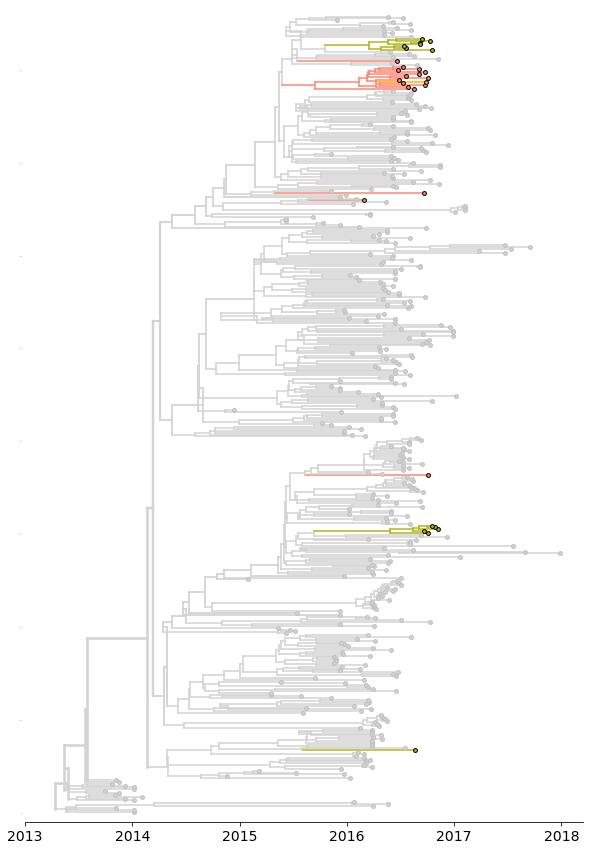

In [93]:
fig,ax = plt.subplots(figsize=(10,15),facecolor='w')
branchWidth=1.5 ## default branch width
tipSize = 15
s=15

root_year = (2018.0492813141684 - tree.root.traits["height"])

islands = ["saint_thomas","saint_croix","saint_john"]

for k in tree.Objects:
    
    if k.traits["division"] in islands:
        color = division_colors[k.traits["division"]]
        under_circle_color = "black"
    else:
        color = "#D3D3D3"
        under_circle_color = "#C0C0C0"
    
    if k.branchType=="leaf":
        x = k.x + root_year 
        y = k.y
        xp = k.parent.x + root_year
        ax.scatter(x,y,s=15, color=color, edgecolor=under_circle_color, zorder=11)#plot tips
        ax.plot([x,xp],[y,y],lw=node_branchwidth,ls='-', color=color)#plot branch leading to tip
        
    elif k.branchType=="node":
        number_children = len(k.leaves)
        node_branchwidth = branchWidth + number_children*0.0025
        y = k.y
        if k.parent.x==None: #this is the root, and matplotlib won't plot Nones. So make x == xp (no branch)
            x=k.x + root_year
            xp = x
        else:
            x = k.x + root_year
            xp = k.parent.x + root_year
            
        child1_y_value = k.children[-1].y
        child2_y_value = k.children[0].y
        
        ax.plot([x,xp],[y,y],lw=node_branchwidth,ls='-',zorder=9, color=color)#horizontal lines between nodes
        ax.plot([x,x],[child1_y_value,child2_y_value],lw=node_branchwidth,ls='-',zorder=9, color=color) #vertical lines at nodes

        
#turn off unnecessary axes etc
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='y',labelsize=0,size=0)
ax.set_ylim(-5,tree.ySpan+5)
ax.set_xlim(2013,2018.2)

plt.savefig("../figures/full-tree-usvi-highlight", dpi=400)
plt.show()

In [ ]:
#now, make exploded tree plot that shows each of these introductions in closer detail

In [104]:
#make a list of all of the possible countries that could be the ancestral state at a node
countries = []
for line in open("../config/colors.tsv"):
    if line.startswith("country"):
        countries.append(line.split('\t')[1])

['french_polynesia', 'fiji', 'american_samoa', 'brazil', 'peru', 'ecuador', 'colombia', 'french_guiana', 'suriname', 'venezuela', 'panama', 'nicaragua', 'honduras', 'el_salvador', 'guatemala', 'belize', 'mexico', 'usa', 'puerto_rico', 'martinique', 'guadeloupe', 'dominican_republic', 'jamaica', 'saint_barthelemy', 'haiti', 'usvi', 'cuba', 'barbados']


In [126]:
#step 1: traverse the tree and make subtrees when the country trait changes.
#need a dictionary to hold my subtrees. The way I'm setting this up,
#this dictionary will have key == country where the subtrees circulated 
#value is a list of tuples, each tuple has the "origin country" (aka, from where the introduction came)
#and the second value in the tuple is the baltic tree object for the subtree.
subtrees_by_deme = {country:[] for country in countries} #dict where subtrees can be grouped by deme they circulate in

#also, I need to specify how I want baltic to traverse these subtrees.
#I only want the portion of the subtree that circulated within a deme. 
#Put more simply, I want to see the introduction into a deme, and then only the
#ciruclation within that deme post introduction. 
traverse_if_country_remains_same=lambda w:w.traits["country"]==k_location 

#okay...actually run the thing now.
for k in sorted(tree.Objects, key=lambda x:x.height):
    if k.height == 0:#Exlude the root of the tree, as it has no parent.
        continue
    else:
        k_location = k.traits["country"]
        k_parent_location = k.parent.traits["country"]
    
        if k_location != k_parent_location: #we have deme change on a branch
            subtree = tree.subtree(k, traverse_condition=traverse_if_country_remains_same)
            subtrees_by_deme[k_location].append((k_parent_location,subtree))
    


(2014.5, 2017.0)

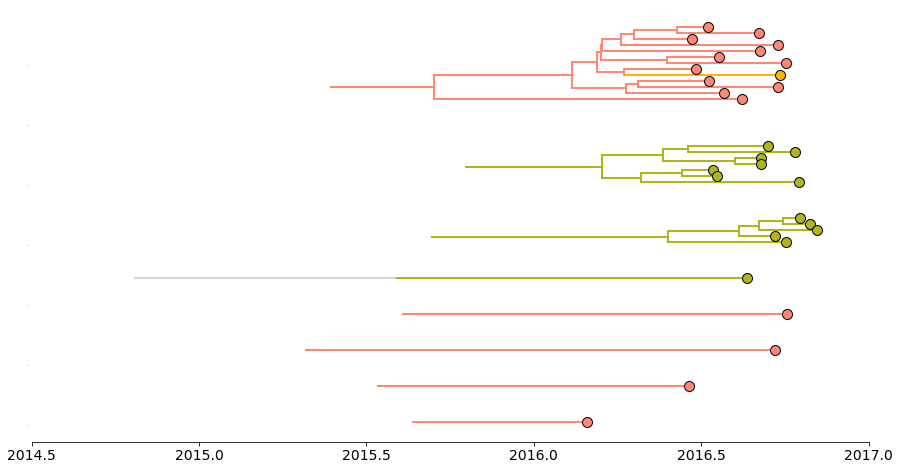

In [185]:
#and now, plot the subtrees
fig,ax = plt.subplots(figsize=(15,8), facecolor="white")

cumulative_y = 0 #need to do a bit of fiddling with y values to make the spacing better on the exploded trees
branchWidth = 2
node_branchwidth = 2
#I want these subtrees sorted by the number of children!
for subtree in sorted(subtrees_by_deme["usvi"], key=lambda x: (len(x[1].Objects))): # I want to sort the clades by size
    export_location = subtree[0]
    introduced_clade = subtree[1]
    
    introduced_clade.sortBranches(descending=False) #this is to reassing y values so that clade spacing is better
    
    for k in introduced_clade.Objects:
        if k.traits["division"] in islands:
            color = division_colors[k.traits["division"]]
            under_circle_color = "black"
        else:
            color = "#D3D3D3"
            under_circle_color = "#C0C0C0"
    
        if k.branchType=="leaf":
            x = k.x + root_year 
            y = k.y/2 + cumulative_y
            xp = k.parent.x + root_year
            ax.scatter(x,y,s=100, color=color, edgecolor=under_circle_color, zorder=11)#plot tips
            ax.plot([x,xp],[y,y],lw=node_branchwidth, ls='-', color=color)#plot branch leading to tip
        
        elif k.branchType=="node":
            number_children = len(k.leaves)
            node_branchwidth = branchWidth + number_children*0.0025
            y = k.y/2 +cumulative_y
            if k.parent.x==None: #this is the root, and matplotlib won't plot Nones. So make x == xp (no branch)
                x=k.x + root_year
                xp = x
            else:
                x = k.x + root_year
                xp = k.parent.x + root_year
            
            child1_y_value = k.children[-1].y/2 + cumulative_y
            child2_y_value = k.children[0].y/2 + cumulative_y

            ax.plot([x,xp],[y,y],lw=node_branchwidth, ls='-',zorder=9, color=color)#horizontal lines between nodes
            ax.plot([x,x],[child1_y_value,child2_y_value],lw=node_branchwidth, ls='-',zorder=9, color=color) #vertical lines at nodes
   
    #customize spacing between the clades a bit.
    if introduced_clade.ySpan <= 1:
        cumulative_y += 3
    else:
        cumulative_y += introduced_clade.ySpan
    
    
#turn off unnecessary axes etc
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='y',labelsize=0,size=0)
ax.set_xlim(2014.5,2017)    
    
    

In [1272]:
'''We essentially want to start at each USVI tip, walk up the tree, and stop when we either move to pre-2016 or out of the USVI'''

def in_usvi_post_2016(k):
    date = k.absoluteTime >= 2016.0
    location = k.traits['country'] == 'united_states_virgin_islands'
    return date and location

introductions = []

for k in linked_list.leaves:
    if not in_usvi_post_2016(k): # if we start in the USVI @ the tip
        continue
    
    mrca = False # walk up the tree until we find the first parent that is NOT in the USVI
    while mrca == False:
        if in_usvi_post_2016(k) and not in_usvi_post_2016(k.parent):
            introductions.append(k) # take the most basal node that IS in the USVI and post-2016, but parent does not meet that criteria
            mrca = True
        k = k.parent
        
introductions = list(set(introductions))

within_country_trees_SB = defaultdict(list)
for mrca in introductions:
    origin = mrca.parent.traits['country']
    destination = mrca.traits['country']
    
#     if isinstance(mrca, bt.node):
    subtree = linked_list.subtree(mrca)
#     else:
#         subtree = mrca
    within_country_trees_SB[destination].append((origin, subtree))
    
within_country_trees_SB = dict(within_country_trees_SB)

In [1277]:
'''
We're now properly parsing and pulling each introduction.
The trick is that the singleton clades 
'''

print introductions
print len(introductions)
print within_country_trees_SB

[<baltic.node instance at 0x154f42c20>, <baltic.leaf instance at 0x168104a70>, <baltic.leaf instance at 0x166ebeab8>, <baltic.leaf instance at 0x166ce3cf8>, <baltic.leaf instance at 0x166ce3518>, <baltic.leaf instance at 0x167eed128>, <baltic.node instance at 0x169512f38>, <baltic.node instance at 0x169568950>, <baltic.leaf instance at 0x169512560>, <baltic.leaf instance at 0x1177887a0>, <baltic.leaf instance at 0x167b8fbd8>, <baltic.leaf instance at 0x1695123f8>]
12
{'united_states_virgin_islands': [('united_states_virgin_islands', <baltic.tree instance at 0x1701fce60>), ('brazil', <baltic.tree instance at 0x164705b90>), ('brazil', <baltic.tree instance at 0x165ee7f80>), ('united_states_virgin_islands', <baltic.tree instance at 0x16a31f320>), ('united_states_virgin_islands', <baltic.tree instance at 0x17535c758>), ('venezuela', <baltic.tree instance at 0x16a33d758>), ('united_states_virgin_islands', <baltic.tree instance at 0x15d372518>), ('dominican_republic', <baltic.tree instance a

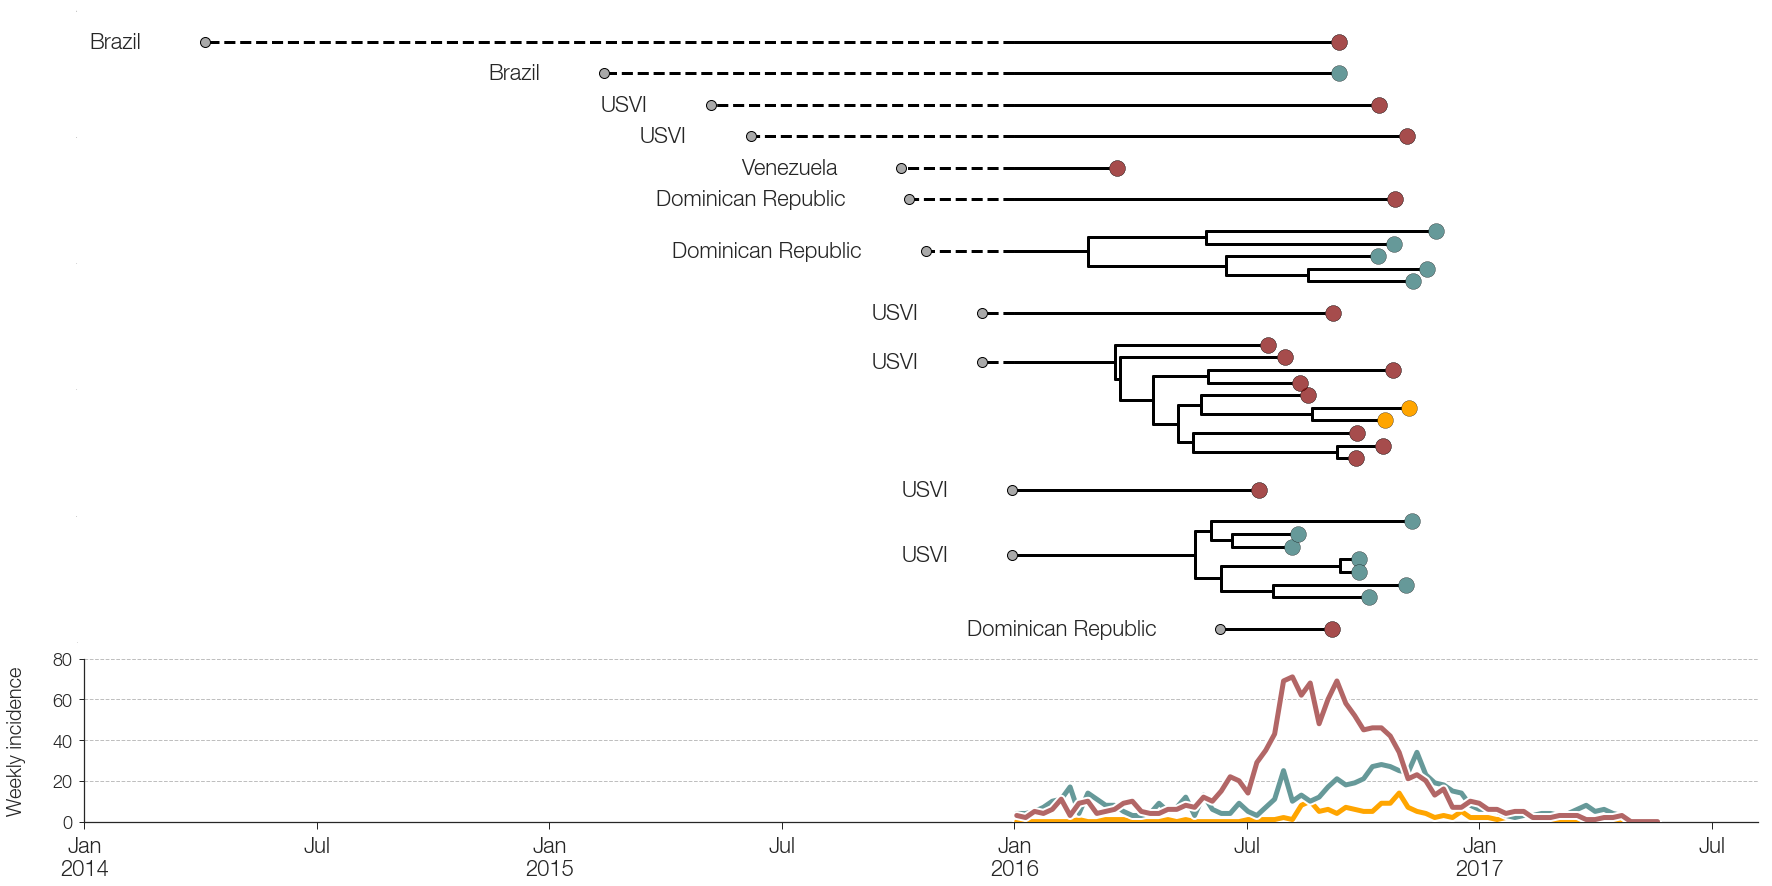

In [1449]:
import matplotlib.patheffects as path_effects

def plot_exploded_tree(subtree_dict):
    #print within_country_trees['united_states_virgin_islands']
    #print subtree_sizes['united_states_virgin_islands']
    usvi_island_colors = {'saint_croix': '#669999', 'saint_thomas': 'maroon' ,'saint_john': 'orange'}

    #usvi_island_colors = {'saint_croix': 'maroon', 'saint_thomas': '#669999' ,'saint_john': '#003333'}
    labeling_dict = {'dominican_republic':'Dominican Republic', 'brazil': 'Brazil', 'venezuela': 'Venezuela', 'united_states_virgin_islands': 'USVI'}

    colorbarTextSize=30 ## add colourbars
    colorbarTickLabelSize=24
    colorbarWidth=0.02
    colorbarHeight=0.4
    colorbarIncrement=0.08

    #ax2 = fig.add_axes([colorbarIncrement*4, 0.13, colorbarHeight, colorbarWidth]) ## add dummy axes
    #mpl.colorbar.ColorbarBase(ax2, cmap=mpl.cm.Greys,orientation='horizontal')
    #color_map = [mpl.cm.Greys(x) for x in np.linspace(0.0,1.0,10)])

    #####

    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1], wspace=0, hspace=0 )

    fig = plt.subplots(figsize=(30,20),facecolor='w')

    branchWidth=3 ## default branch width
    tipSize = 250

    ax = plt.subplot(gs[0])
    cumulative_y = 0
    #for origin,subtree in within_country_trees['united_states_virgin_islands']: #iterating over introductions to the USVI
    #for origin,subtree in sorted(within_country_trees['united_states_virgin_islands'],key=lambda x: (len(x[1].leaves), x[1].root.absoluteTime),reverse=True):
    for origin,subtree in sorted(subtree_dict['united_states_virgin_islands'],key=lambda x: (x[1].root.absoluteTime,len(x[1].leaves)),reverse=True):
        for k in subtree.Objects:
            x = k.absoluteTime
            y = k.y
            if k.parent.x == None:
                xp = x
            else:  
                xp = k.parent.absoluteTime

            #branch_color='lightgrey'
            branch_color = mpl.cm.Greys(k.traits['country.prob'])

            if isinstance(k,bt.leaf): ## leaves have circles at tips
                island = usvi_specific_island[k.name.split('|')[0]]
                
                try:
                    color = usvi_island_colors[island]
                except:
                    color='purple'
                if island == 'saint_thomas':
                    ax.scatter(x,y+cumulative_y,s=tipSize,facecolor='white', alpha=1,edgecolor='black',zorder=99)
                    ax.scatter(x,y+cumulative_y,s=tipSize,facecolor=color, alpha=0.7,edgecolor='black',zorder=100) ## plot tip circle
                else:
                    ax.scatter(x,y+cumulative_y,s=tipSize,facecolor=color, alpha=1.0,edgecolor='black',zorder=100) ## plot tip circle
                #ax.scatter(x,y+cumulative_y,s=tipSize+50,facecolor='k',edgecolor='none',zorder=99)

            elif isinstance(k,bt.node): ## nodes have vertical lines
                child1_y=k.children[0].y
                child2_y=k.children[-1].y
                ax.plot([x,x],[child1_y+cumulative_y,child2_y+cumulative_y],color=branch_color,lw=branchWidth,zorder=98) ## plot vertical bar 
            ax.plot([x,xp],[y+cumulative_y,y+cumulative_y],color=branch_color,lw=branchWidth,zorder=98) ## plot branch

        min_node_x = min(k.absoluteTime for k in subtree.Objects)        
        origin_color='darkgrey'

        if subtree.Objects[0].absoluteTime==None:
            origin_prob = subtree.Objects[0].traits['country.prob']
            origin_x=subtree.Objects[0].absoluteTime #sending country has same x coord as root in receiving country.
            origin_y=subtree.Objects[0].y+cumulative_y #and same for the y coordinates
        else:
            origin_prob = subtree.Objects[0].traits['country.prob']
            origin_x=subtree.Objects[0].parent.absoluteTime
            origin_y=subtree.Objects[0].y+cumulative_y

        if origin!='ancestor': ## add text if not dealing with the very first introduction into the americas
            ax.text(origin_x-50/365.0,origin_y,'{}'.format(labeling_dict[origin]),ha='right',va='center', size=22) #label origin country
            #ax.text(origin_x-30/365.0,origin_y-1.5,'posterior: {0:.2f}'.format(origin_prob),ha='right',va='center', size=18)
            ax.scatter(origin_x,origin_y,100,facecolor=origin_color,edgecolor='black',lw=1,zorder=200) ## circle at the base of the subtree to indicate origin
            
            if min_node_x < 2016.0: # whole thing before 2016
                ax.plot([min_node_x,origin_x],[origin_y,origin_y], '--', color=branch_color,lw=branchWidth,zorder=98)

            elif origin_x < 2016.0: # partly before 2016
                ax.plot([min_node_x,2016.0],[origin_y,origin_y],'-',color=branch_color,lw=branchWidth,zorder=98)
                ax.plot([2016.0,origin_x],[origin_y,origin_y],'--',color=branch_color,lw=branchWidth,zorder=98)
            else:
                ax.plot([min_node_x,origin_x],[origin_y,origin_y],'-',color=branch_color,lw=branchWidth,zorder=98)

                
        cumulative_y += max([x.y for x in subtree.Objects])+1.5 ## increment y position

    #Remove lines from sides of plot that I don't like
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    #ax.set_xticks([2014.0, 2014.5, 2015.0, 2015.5, 2016.0, 2016.5, 2017.0, 2017.5, 2018.0 ])
    ax.set_xticklabels([])


    ax.tick_params(axis='y',labelsize=0,size=0)
    ax.tick_params(axis='top',labelsize=0,size=0)
    ax.tick_params(axis='bottom',labelsize=0,size=0)

    ax.set_xlim(2014,2017.6)
    #ax.set_ylabel('Introductions to USVI, by island',size=20)

    '''ax.axvline(2014.0,ls='--',color='grey', linewidth = 1, alpha = 0.5)
    ax.axvline(2015.0,ls='--',color='grey', linewidth = 1, alpha = 0.5)
    ax.axvline(2016.0,ls='--',color='grey', linewidth = 1, alpha = 0.5)
    ax.axvline(2017.0,ls='--',color='grey', linewidth = 1, alpha = 0.5)
    ax.axvline(2018.0,ls='--',color='grey', linewidth = 1, alpha = 0.5)'''

    #labels = [2014.0, 2014.5, 2015.0, 2015.5, 2016.0, 2016.5, 2017.0, 2017.5, 2018.0 ]
    #ax.set_xticklabels([decimalDateToAxisLabel(label) for label in labels])


    '''ax.scatter(2014.08,25,s=400,facecolor=usvi_island_colors['saint_croix'],edgecolor='black',zorder=10) ## 
    ax.scatter(2014.08,22,s=400,facecolor='white', alpha = 1, edgecolor='black',zorder=9) ## 
    ax.scatter(2014.08,22,s=400,facecolor=usvi_island_colors['saint_thomas'], alpha = 0.7, edgecolor='black',zorder=10) ## plot white circle underneath bc alpha is low
    ax.scatter(2014.08,19,s=400,facecolor=usvi_island_colors['saint_john'],edgecolor='black',zorder=10) 

    ax2.text(2014,24.5, 'Saint Thomas', size=40, color=usvi_island_colors['saint_thomas'],alpha=0.8)
    ax2.text(2014,21.5, 'Saint Croix', size=40, color=usvi_island_colors['saint_croix'])
    ax2.text(2014,18.5, 'Saint John', size=40, color=usvi_island_colors['saint_john'])
    '''

#     effects=[path_effects.Stroke(linewidth=0.5, foreground='white'),path_effects.Stroke(linewidth=0.5, foreground='black')]

#     ax.text(2014.,26, 'Saint Thomas', size=50, color=usvi_island_colors['saint_thomas'],alpha=0.8, path_effects=effects)
#     ax.text(2014.,22, 'Saint Croix', size=50, color=usvi_island_colors['saint_croix'],path_effects=effects)
#     ax.text(2014.,18, 'Saint John', size=50, color=usvi_island_colors['saint_john'], path_effects=effects)

    #timeline = np.arange(2014, 2018.0833333333333, 0.08333333333333333)
    #[ax.axvspan(timeline[i],timeline[i+1],facecolor='k',edgecolor='none',alpha=0.04) for i in range(0,len(timeline)-1,2)]


    #### 2nd panel: incidence

    ax2 = plt.subplot(gs[1])
    islands = ['saint_croix', 'saint_thomas', 'saint_john']

    for island in islands:
        x_values = [decimalDate(x) for x in usvi_df['date']]
        y_values = [y for y in usvi_df[island]]

        if island == 'saint_thomas':
            ax2.plot(x_values,y_values,color=usvi_island_colors[island], alpha = 0.6,lw=5,label='x',zorder=int(sum(y_values)))
        else:
            ax2.plot(x_values,y_values,color=usvi_island_colors[island], alpha = 1,lw=5,label='x',zorder=int(sum(y_values)))
        ax2.plot(x_values,y_values,color='w',lw=9,zorder=int(sum(y_values))-1)

    ax2.set_xlim(2014,2017.6)

    default_ticks = ax2.get_xticks()
    ax2.set_xticklabels([decimalDateToAxisLabel(x) for x in default_ticks])

    ax2.set_ylabel('Weekly incidence\n',size=20)
    ax2.set_ylim(0,80)

    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

    ax2.tick_params(axis='x',labelsize=22, which='major', width=1, size=7)
    ax2.tick_params(axis='y',labelsize=18, width=1, size=5)

    '''ax2.axvline(2014.0,ls='--',color='grey', linewidth = 1, alpha = 0.5)
    ax2.axvline(2015.0,ls='--',color='grey', linewidth = 1, alpha = 0.5)
    ax2.axvline(2016.0,ls='--',color='grey', linewidth = 1, alpha = 0.5)
    ax2.axvline(2017.0,ls='--',color='grey', linewidth = 1, alpha = 0.5)
    ax2.axvline(2018.0,ls='--',color='grey', linewidth = 1, alpha = 0.5)'''


    ax2.axhline(20,ls='--',color='grey', linewidth = 1, alpha = 0.5)
    ax2.axhline(40,ls='--',color='grey', linewidth = 1, alpha = 0.5)
    ax2.axhline(60,ls='--',color='grey', linewidth = 1, alpha = 0.5)
    ax2.axhline(80,ls='--',color='grey', linewidth = 1, alpha = 0.5)
    '''
    effects=[path_effects.Stroke(linewidth=0.5, foreground='white'),path_effects.Stroke(linewidth=0.5, foreground='black')]

    ax2.text(2014.1,61, 'Saint Thomas', size=50, color=usvi_island_colors['saint_thomas'],alpha=0.8, path_effects=effects)
    ax2.text(2014.1,41, 'Saint Croix', size=50, color=usvi_island_colors['saint_croix'],path_effects=effects)
    ax2.text(2014.1,21, 'Saint John', size=50, color=usvi_island_colors['saint_john'], path_effects=effects)
    #ax2.axvline(decimalDate('2016-01-20'),ls='--',color='grey', linewidth = 1, alpha = 0.5)
    '''

    #[ax2.axvspan(timeline[i],timeline[i+1],facecolor='k',edgecolor='none',alpha=0.04) for i in range(0,len(timeline)-1,2)]

#     plt.savefig('/Users/alliblk/Desktop/gitrepos/zika-usvi/figures/usvi_introductions_and_incidence_transparent.png', transparent=True)
#     plt.savefig('/Users/alliblk/Desktop/gitrepos/zika-usvi/figures/usvi_introductions_and_incidence_transparent.pdf', transparent=True)

    #plt.show()
    plt.savefig('/Users/alliblk/Desktop/gitrepos/zika-usvi/figures/clusters_colored_by_island.pdf', transparent=True)
    

plot_exploded_tree(within_country_trees_SB)

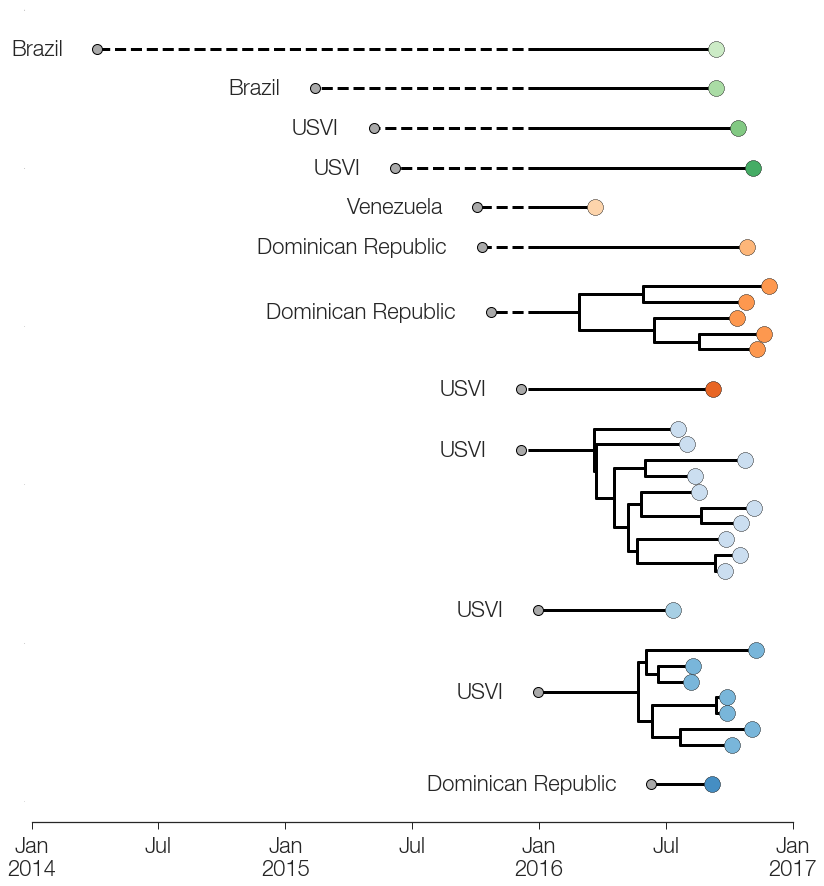

In [1497]:
import matplotlib.patheffects as path_effects

def plot_exploded_tree(subtree_dict):
    #print within_country_trees['united_states_virgin_islands']
    #print subtree_sizes['united_states_virgin_islands']
    usvi_island_colors = {'saint_croix': '#669999', 'saint_thomas': 'maroon' ,'saint_john': 'orange'}

    #usvi_island_colors = {'saint_croix': 'maroon', 'saint_thomas': '#669999' ,'saint_john': '#003333'}
    labeling_dict = {'dominican_republic':'Dominican Republic', 'brazil': 'Brazil', 'venezuela': 'Venezuela', 'united_states_virgin_islands': 'USVI'}

    colorbarTextSize=30 ## add colourbars
    colorbarTickLabelSize=24
    colorbarWidth=0.02
    colorbarHeight=0.4
    colorbarIncrement=0.08

    #ax2 = fig.add_axes([colorbarIncrement*4, 0.13, colorbarHeight, colorbarWidth]) ## add dummy axes
    #mpl.colorbar.ColorbarBase(ax2, cmap=mpl.cm.Greys,orientation='horizontal')
    #color_map = [mpl.cm.Greys(x) for x in np.linspace(0.0,1.0,10)])

    #####

    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.2, hspace=0 )

    fig = plt.subplots(figsize=(30,15),facecolor='w')

    branchWidth=3 ## default branch width
    tipSize = 250

    ax = plt.subplot(gs[0])
    cumulative_y = 0
    counter = 0
    
    #for origin,subtree in within_country_trees['united_states_virgin_islands']: #iterating over introductions to the USVI
    #for origin,subtree in sorted(within_country_trees['united_states_virgin_islands'],key=lambda x: (len(x[1].leaves), x[1].root.absoluteTime),reverse=True):
    for origin,subtree in sorted(subtree_dict['united_states_virgin_islands'],key=lambda x: (x[1].root.absoluteTime,len(x[1].leaves)),reverse=True):
        color = mpl.cm.tab20c(counter)
        #color = mpl.cm.plasma(counter)
        counter += 1
        for k in subtree.Objects:
            x = k.absoluteTime
            y = k.y
            if k.parent.x == None:
                xp = x
            else:  
                xp = k.parent.absoluteTime

            #branch_color='lightgrey'
            #branch_color = mpl.cm.Greys(k.traits['country.prob'])

            if isinstance(k,bt.leaf): ## leaves have circles at tips
                ax.scatter(x,y+cumulative_y,s=tipSize,facecolor='white', alpha=1,edgecolor='black',zorder=99)
                ax.scatter(x,y+cumulative_y,s=tipSize,facecolor=color, alpha=0.9,edgecolor='black',zorder=100)
            

            elif isinstance(k,bt.node): ## nodes have vertical lines
                child1_y=k.children[0].y
                child2_y=k.children[-1].y
                ax.plot([x,x],[child1_y+cumulative_y,child2_y+cumulative_y],color=branch_color,lw=branchWidth,zorder=98) ## plot vertical bar 
            ax.plot([x,xp],[y+cumulative_y,y+cumulative_y],color=branch_color,lw=branchWidth,zorder=98) ## plot branch

        min_node_x = min(k.absoluteTime for k in subtree.Objects)        
        origin_color='darkgrey'

        if subtree.Objects[0].absoluteTime==None:
            origin_prob = subtree.Objects[0].traits['country.prob']
            origin_x=subtree.Objects[0].absoluteTime #sending country has same x coord as root in receiving country.
            origin_y=subtree.Objects[0].y+cumulative_y #and same for the y coordinates
        else:
            origin_prob = subtree.Objects[0].traits['country.prob']
            origin_x=subtree.Objects[0].parent.absoluteTime
            origin_y=subtree.Objects[0].y+cumulative_y

        if origin!='ancestor': ## add text if not dealing with the very first introduction into the americas
            ax.text(origin_x-50/365.0,origin_y,'{}'.format(labeling_dict[origin]),ha='right',va='center', size=22) #label origin country
            #ax.text(origin_x-30/365.0,origin_y-1.5,'posterior: {0:.2f}'.format(origin_prob),ha='right',va='center', size=18)
            ax.scatter(origin_x,origin_y,100,facecolor=origin_color,edgecolor='black',lw=1,zorder=200) ## circle at the base of the subtree to indicate origin
            
            if min_node_x < 2016.0: # whole thing before 2016
                ax.plot([min_node_x,origin_x],[origin_y,origin_y], '--', color=branch_color,lw=branchWidth,zorder=98)

            elif origin_x < 2016.0: # partly before 2016
                ax.plot([min_node_x,2016.0],[origin_y,origin_y],'-',color=branch_color,lw=branchWidth,zorder=98)
                ax.plot([2016.0,origin_x],[origin_y,origin_y],'--',color=branch_color,lw=branchWidth,zorder=98)
            else:
                ax.plot([min_node_x,origin_x],[origin_y,origin_y],'-',color=branch_color,lw=branchWidth,zorder=98)

                
        cumulative_y += max([x.y for x in subtree.Objects])+1.5 ## increment y position

    #Remove lines from sides of plot that I don't like
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    #ax.set_xticks([2014.0, 2014.5, 2015.0, 2015.5, 2016.0, 2016.5, 2017.0, 2017.5, 2018.0 ])
    #ax.set_xticklabels([])

    ax.tick_params(axis='x',labelsize=22, which='major', width=1, size=7)
    ax.tick_params(axis='y',labelsize=0,size=0)
    ax.tick_params(axis='top',labelsize=0,size=0)
    ax.tick_params(axis='bottom',labelsize=0,size=0)

    ax.set_xlim(2014.,2017.)
    default_ticks = ax.get_xticks()
    ax.set_xticklabels([decimalDateToAxisLabel(x) for x in default_ticks])

    #### 2nd panel: incidence

#     ax2 = plt.subplot(gs[1])
#     counter = 0
#     yposition = 100
    
#     for origin,subtree in sorted(subtree_dict['united_states_virgin_islands'],key=lambda x: (x[1].root.absoluteTime,len(x[1].leaves)),reverse=True):
#         color = mpl.cm.tab20c(counter)
#         for k in subtree.Objects:
#             if isinstance(k,bt.leaf): ## leaves have circles at tips
#                 date = decimalDate(k.name.split('|')[1],'%Y-%m-%d')
#                 #ax2.scatter(date,counter,s=60,facecolor='white', alpha=1,edgecolor='black',zorder=99)
#                 ax2.scatter(date,yposition,s=250,facecolor=color, alpha=1,edgecolor='black',zorder=100) ## plot tip circle
#         #ax2.axhline(yposition, ls='--', lw=1, color='lightgrey')
#         yposition += 15
        
#         counter += 1
#         #Remove lines from sides of plot that I don't like
#     ax2.plot(x_values, usvi_df['total_cases'], ls='-', lw=4, color='darkgrey')

         
# #     #ax2.xaxis_date()
# #     ax2.set_ylim(0,290)
# #     #ax2.set_xlim(dt.strptime('2014-1-1','%Y-%m-%d'), dt.strptime('2017-1-1','%Y-%m-%d'))
# #     ax2.spines['top'].set_visible(False)
# #     ax2.spines['left'].set_visible(False)
# #     ax2.spines['right'].set_visible(False)
# #     #ax2.spines['bottom'].set_visible(False)

        
        
#     ax2.spines['top'].set_visible(False)
#     ax2.spines['right'].set_visible(False)
#     ax2.spines['left'].set_visible(False)


# #     ax2.tick_params(axis='y',labelsize=0,size=0)
# #     ax2.tick_params(axis='top',labelsize=0,size=0)
# #     ax2.tick_params(axis='bottom',labelsize=0,size=0)

# #     ax2.set_xlim(2014.0,2017.)

# #     default_ticks = ax2.get_xticks()
# #     ax2.set_xticklabels([decimalDateToAxisLabel(x) for x in default_ticks])

# #     ax2.tick_params(axis='x',labelsize=22, which='major', width=1, size=7)
# #     ax2.tick_params(axis='y',labelsize=0, which='major', width=0, size=0)
    #plt.show()
    plt.savefig('/Users/alliblk/Desktop/gitrepos/zika-usvi/figures/min_2016_transmission_clusters.pdf', transparent=True)
    

plot_exploded_tree(within_country_trees_SB)

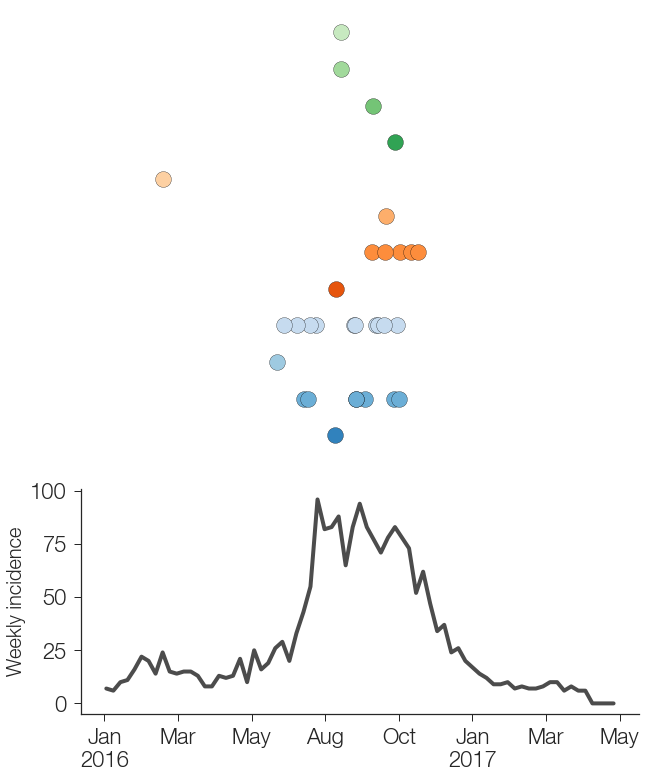

In [1517]:
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1], wspace=0, hspace=0.1 )

fig,ax = plt.subplots(figsize=(10, 13),facecolor='w')

ax = plt.subplot(gs[1])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
ax.plot(x_values, usvi_df['total_cases'], ls='-', lw=4, color='black',alpha=0.7)

ax.tick_params(axis='x',labelsize=22, which='major', width=1, size=7)
ax.tick_params(axis='y',labelsize=22, which='major', width=1, size=7)

default_ticks = ax.get_xticks()
ax.set_xticklabels([decimalDateToAxisLabel(x) for x in default_ticks])
ax.set_ylabel('Weekly incidence', size=20)

# ax.set_ylabel('Weekly incidence\n',size=20)
# ax.set_ylim(0,120)

# dates = [dt.strptime(x,'%Y-%m-%d') for x in usvi_df['date']]

# saint_john_cases = usvi_df['saint_john']
# saint_thomas_cases = usvi_df['saint_thomas']
# saint_croix_cases = usvi_df['saint_croix']
# total_cases = usvi_df['total_cases']

# plt.bar(dates, total_cases, align='center', width=5, alpha=1, color='darkgrey')
# # plt.bar(dates, saint_thomas_cases, align='center', width = 5, alpha=1, color='darkgrey')
# # plt.bar(dates, saint_croix_cases, align='center', width = 5, alpha=1, color='darkgrey')
# # plt.bar(dates, saint_john_cases, align='center', width = 5, alpha=1, color='darkgrey')

# ax.xaxis_date()
# weekFormatter = DateFormatter('%b\n%Y')              
# ax.xaxis.set_major_formatter(weekFormatter)
# print ax.get_xticks()

# ax.set_ylabel('Weekly incidence\n',size=20)
# ax.set_ylim(0,120)
# #ax.set_xlim(-8, 70)

# ax.spines['top'].set_visible(False)
# ax.spines['left'].set_visible(True)
# ax.spines['right'].set_visible(False)

# ax.tick_params(axis='x',labelsize=15, width=1, size=7)
# ax.tick_params(axis='y',labelsize=15, width=1, size=5)

# # ax.scatter(dt.strptime('2017-03-01','%Y-%m-%d'),75,s=800,facecolor=usvi_island_colors['saint_john'],marker="_", linewidth=4) 
# # ax.scatter(dt.strptime('2017-03-01','%Y-%m-%d'),68,s=800,facecolor=usvi_island_colors['saint_croix'], marker="_", linewidth=4) ## 
# # ax.scatter(dt.strptime('2017-03-01','%Y-%m-%d'),61,s=800,facecolor=usvi_island_colors['saint_thomas'],marker="_", alpha=0.8, linewidth=4) ## plot white circle underneath bc alpha is low

# # ax.text(dt.strptime('2017-03-20','%Y-%m-%d'),73, 'Saint John', size=18)
# # ax.text(dt.strptime('2017-03-20','%Y-%m-%d'),66, 'Saint Croix', size=18)
# # ax.text(dt.strptime('2017-03-20','%Y-%m-%d'),59, 'Saint Thomas', size=18)

ax2 = plt.subplot(gs[0])
counter = 0
yposition = 5

for origin,subtree in sorted(within_country_trees_SB['united_states_virgin_islands'],key=lambda x: (x[1].root.absoluteTime,len(x[1].leaves)),reverse=True):
    for k in subtree.Objects:
        color = mpl.cm.tab20c(counter)
        if isinstance(k,bt.leaf): ## leaves have circles at tips
            date = decimalDate(k.name.split('|')[1],'%Y-%m-%d')
            ax2.scatter(date,yposition,s=250,facecolor=color, alpha=1.0,edgecolor='black',zorder=100) 
    counter += 1
    yposition+= 10

ax2.set_xlim(2016.0, 2017.5)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.set_xticks([])
ax2.set_yticks([])
#ax2.set_xlim(, max(dates))

#ax2.set_xlim(735938.05000000005, 736497.94999999995)

# default_ticks = ax2.get_xticks()
# ax2.set_xticklabels([decimalDateToAxisLabel(x) for x in default_ticks])

# ax2.tick_params(axis='y',labelsize=0, which='major', width=0, size=0)
#plt.show()
plt.savefig('/Users/alliblk/Desktop/gitrepos/zika-usvi/figures/clusters_time_series.pdf', transparent=True)

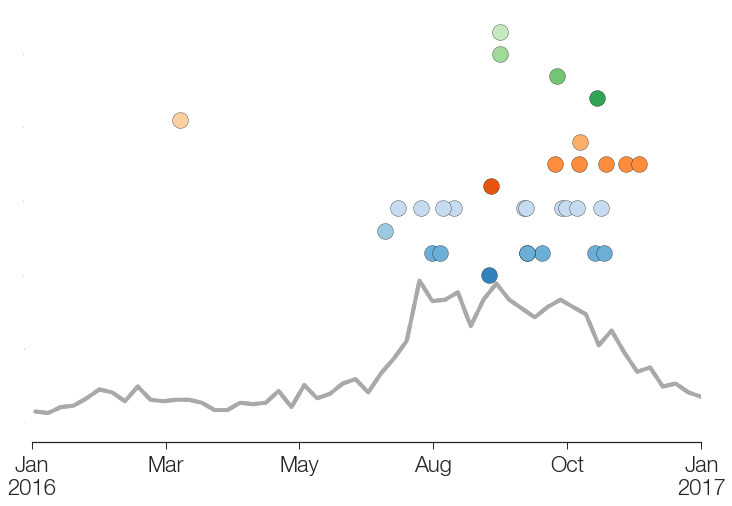

In [1432]:
fig,ax2 = plt.subplots(figsize=(12, 8),facecolor='w')
ax2.plot(x_values, usvi_df['total_cases'], ls='--', lw=4, color='darkgrey')

counter=0
yposition = 100
ax2.set_xlim(2016.0,2017.0)
for origin,subtree in sorted(within_country_trees_SB['united_states_virgin_islands'],key=lambda x: (x[1].root.absoluteTime,len(x[1].leaves)),reverse=True):    
    color = mpl.cm.tab20c(counter)
    for k in subtree.Objects:
        if isinstance(k,bt.leaf): ## leaves have circles at tips
            date = decimalDate(k.name.split('|')[1],'%Y-%m-%d')
            ax2.scatter(date,yposition,s=250,facecolor=color, alpha=1,edgecolor='black',zorder=100) ## plot tip circle
    #ax2.axhline(yposition, ls='--', lw=1, color='lightgrey')
    yposition += 15
    counter += 1
    #Remove lines from sides of plot that I don't like
ax2.plot(x_values, usvi_df['total_cases'], ls='-', lw=4, color='darkgrey')

#ax2.xaxis_date()
#ax2.set_ylim(0,290)
#ax2.set_xlim(dt.strptime('2014-1-1','%Y-%m-%d'), dt.strptime('2017-1-1','%Y-%m-%d'))
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)

#ax2.spines['bottom'].set_visible(False)



#     ax2.spines['top'].set_visible(False)
#     ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)


#     ax2.tick_params(axis='y',labelsize=0,size=0)
#     ax2.tick_params(axis='top',labelsize=0,size=0)
#     ax2.tick_params(axis='bottom',labelsize=0,size=0)


default_ticks = ax2.get_xticks()
ax2.set_xticklabels([decimalDateToAxisLabel(x) for x in default_ticks])

ax2.tick_params(axis='x',labelsize=22, which='major', width=1, size=7)
ax2.tick_params(axis='y',labelsize=0, which='major', width=0, size=0)
plt.show()


In [447]:
#group countries and colors.
northAm = []
southAm = []
centralAm = []
carib = []
countries = []

with open('/Users/alliblk/Desktop/gitrepos/zika-usvi/data/glm/indexed-countries-45.tsv','r') as file:
    for line in file:
        if line.startswith('country'):
            continue
        else:
            countries.append(line.split('\t')[0])
            if line.split('\t')[1].strip() == 'north_america':
                northAm.append(line.split('\t')[0])
            elif line.split('\t')[1].strip() == 'central_america':
                centralAm.append(line.split('\t')[0])
            elif line.split('\t')[1].strip() == 'south_america':
                southAm.append(line.split('\t')[0])
            elif line.split('\t')[1].strip() == 'caribbean':
                carib.append(line.split('\t')[0])                

print len(southAm)
print len(northAm)
print len(carib) 
print len(centralAm)
print len(countries)

northAmcolor = '#ddcc77'#'#44AA99'
southAmcolor =  '#332288'#'#CC6677'
centralAmcolor = '#AA4499'
caribColor = '#999933'

13
4
21
7
45


In [462]:
#Colors
#North America
color_dict = {
        "united_states":"#a1d99b", 
        "mexico":"#41ab5d",
           
		"colombia":"#eff3ff",
		"venezuela":"#c6dbef",
		"french_guiana":"#9ecae1",
		"suriname":"#6baed6",
		"ecuador":"#4292c6",
		"peru": "#2171b5",
        "brazil": "#084594",
				
		"guatemala":"#fa9fb5",
		"el_salvador":"#f768a1",
        "honduras":"#dd3497",
        "nicaragua":"#ae017e",
		"panama":"#7a0177",
		
		"cuba":"#fff5f0",
    	"jamaica":"#fee0d2",
		"haiti":"#fcbba1",
		"dominican_republic":"#fc9272",
		"puerto_rico": "#fb6a4a",
		"united_states_virgin_islands":"#ef3b2c",
		"guadeloupe":"#cb181d",
		"martinique":"#99000d"

}

In [1116]:
for k in linked_list.Objects:
    if isinstance(k,bt.leaf):
        print k.name

USA/2016/FLWB044|2016-09-28|north_america|united_states
USA/2016/FLSR043|2016-09-28|north_america|united_states
NIC/8610_13A1/2016|2016-07-07|north_america|nicaragua
HND/2016/HU_ME33|2016-04-28|north_america|honduras
NIC/4886_12A1/2016|2016-07-10|north_america|nicaragua
NIC/7252_12A1/2016|2016-06-29|north_america|nicaragua
HND/2016/HU_ME147|2016-06-04|north_america|honduras
HND/2016/HU_ME38|2016-04-30|north_america|honduras
HND/2016/HU_ME42|2016-05-09|north_america|honduras
HN16|2016-05-16|north_america|honduras
HND/2016/HU_ME58|2016-05-13|north_america|honduras
HND/2016/HU_ME156|2016-06-07|north_america|honduras
NIC/6406_13A1/2016|2016-05-29|north_america|nicaragua
Nica1_16|2016-01-19|north_america|nicaragua
Nica2_16|2016-01-13|north_america|nicaragua
HND/2016/HU_SZ76|2016-05-03|north_america|honduras
HND/2016/HU_ME131|2016-05-28|north_america|honduras
FHT1166/HON/2016|2016-08-26|north_america|honduras
HND/2016/HU_ME172|2016-06-10|north_america|honduras
HND/2016/HU_ME171|2016-06-10|no

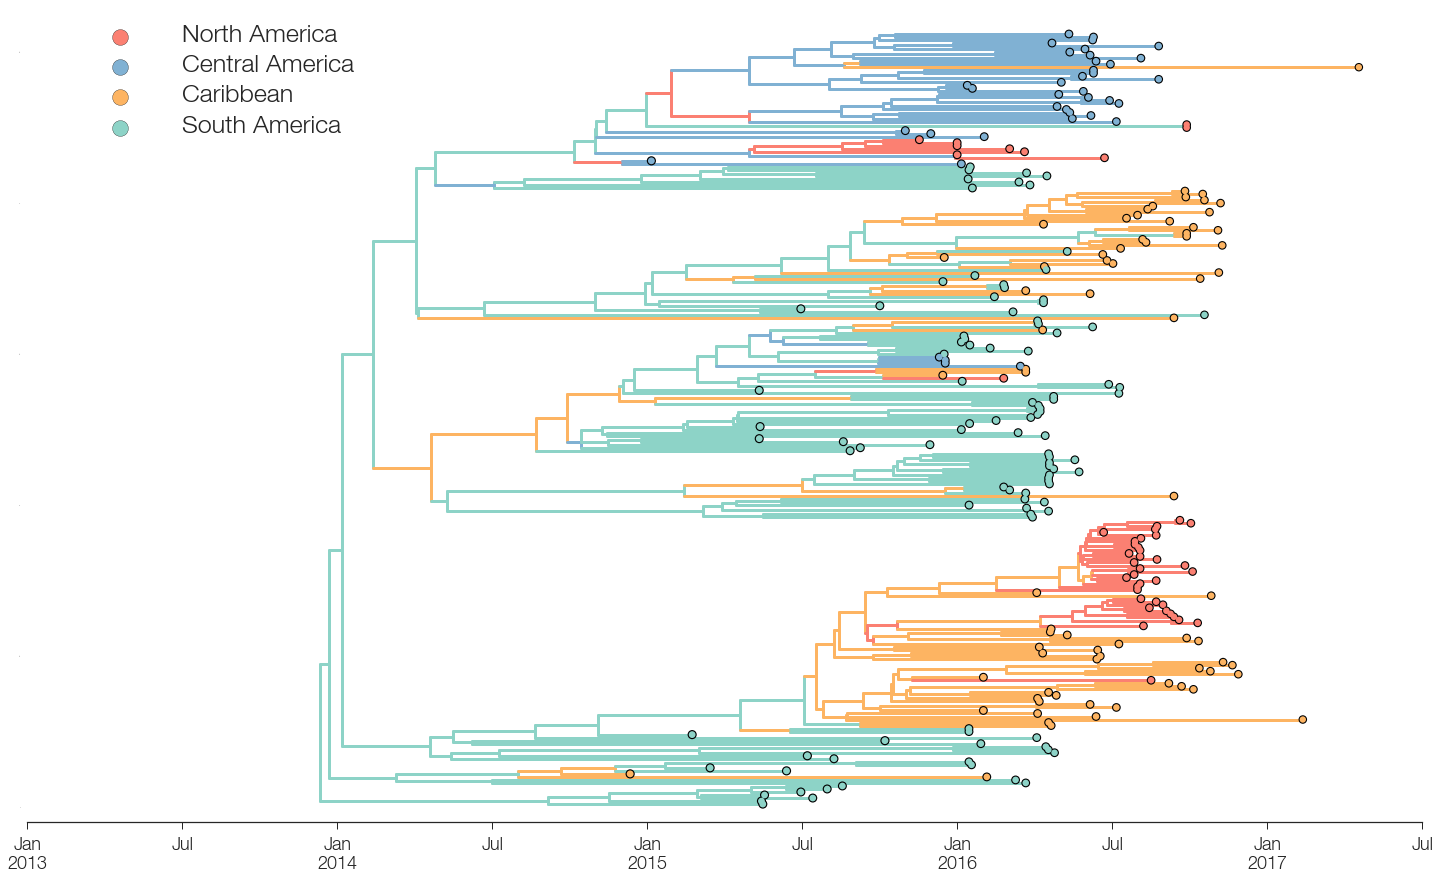

In [1105]:
#This works when x values remain as ages from youngest tip.
#Tree plots BACKWARDS when AbsoluteTime is used...WHY???
### NOTE: root x value is 0, and .x values count from that. this is opposite to figtree where 0 == youngest tip!
fig,ax = plt.subplots(figsize=(25,15),facecolor='w')
branchWidth=3 ## default branch width

for k in linked_list.Objects:
    x = k.absoluteTime
    y = k.y
    xp = k.parent.absoluteTime
    if xp == None:
        xp = x ## get x position of current node's parent
    
    if isinstance(k,bt.leaf):
        #color = color_dict[k.name.split('|')[3]]
        '''
        if float(k.traits['country.prob']) > 0.99:
            color = color_dict[k.traits['country']]
        else:
            color = 'grey'
        '''
        if k.name.split('|')[3] in northAm:
            color = '#fb8072'
        elif k.name.split('|')[3] in southAm:
            color = "#8dd3c7"
        elif k.name.split('|')[3] in centralAm:
            color = "#80b1d3"
        elif k.name.split('|')[3] in carib:
            color = "#fdb462"
    
        s=50-10*k.height/linked_list.treeHeight #size to draw the circle
        ax.scatter(x,y,s=s,facecolor=color,edgecolor='none',zorder=11) ## plot circle for every tip
        ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
    
    elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
        ax.plot([x,x],[k.children[0].y,k.children[1].y],lw=branchWidth,color=color,ls='-',zorder=9) # x to x, these are the vertical branches
        
    ax.plot([xp,x],[y,y],lw=branchWidth,color=color,ls='-',zorder=9)

#Remove lines from sides of plot that I don't like
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
#ax.spines['bottom'].set_visible(False)

ax.tick_params(axis='y',labelsize=0,size=0)
ax.tick_params(axis='x',labelsize=18,size=0)

ax.set_xlim(2013,2017.5)
ax.set_ylim(-5,len(linked_list.Objects)/2+10)

default_ticks = ax.get_xticks()
ax.set_xticklabels([decimalDateToAxisLabel(x) for x in default_ticks])
ax.tick_params(axis='x',labelsize=18, which='major', width=1, size=7)


#make legend
ax.scatter(2013.3,255,s=250,facecolor='#fb8072',edgecolor='black',zorder=10) ## plot circle for node
ax.scatter(2013.3,245,s=250,facecolor='#80b1d3',edgecolor='black',zorder=10) ## plot black circle underneath
ax.scatter(2013.3,235,s=250,facecolor='#fdb462',edgecolor='black',zorder=10) ## plot circle for node
ax.scatter(2013.3,225,s=250,facecolor='#8dd3c7',edgecolor='black',zorder=10) ## plot circle for node

ax.text(2013.5,253.5, 'North America', size=25)
ax.text(2013.5,243.5, 'Central America', size=25)
ax.text(2013.5,233.5, 'Caribbean', size=25)
ax.text(2013.5,223.5, 'South America', size=25)


plt.savefig('/Users/alliblk/Desktop/gitrepos/zika-usvi/figures/americas_tree_transparent.png', transparent=True)
plt.savefig('/Users/alliblk/Desktop/gitrepos/zika-usvi/figures/americas_tree_transparent.pdf', transparent=True)


3.35114668727


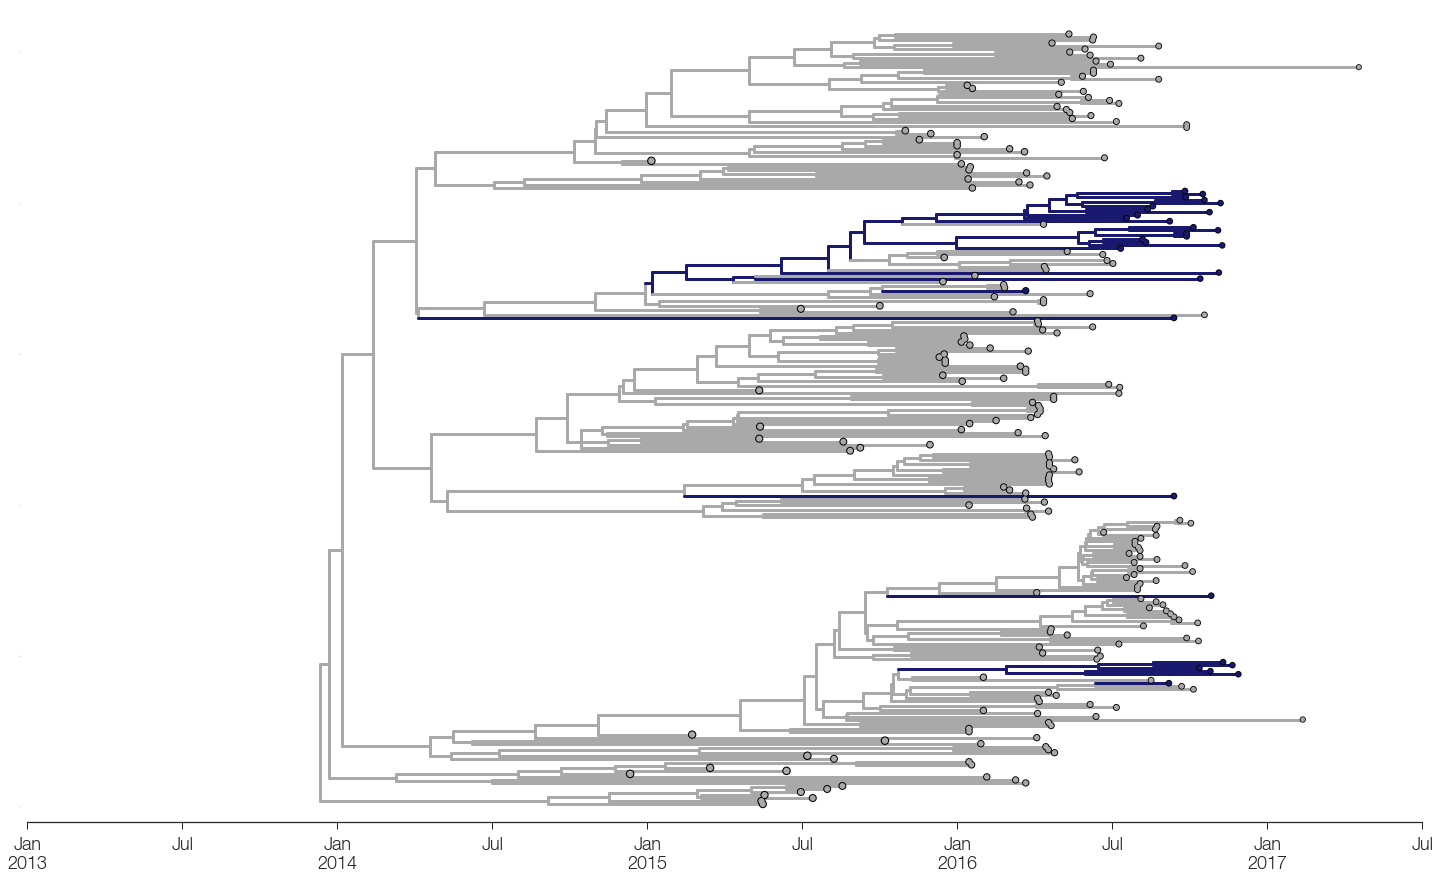

In [1152]:
#here's how to make plotting in absolute time scale work!
#note there's a bit of weirdness because k.x is counted up from root = 0, not the difference in age to the youngest tip
#that means that to get number of years behind the highest tip, you need to know the distance from the leaf k.x value to the node k.x value
#which is the youngest tip's k.x value - your node's k.x value. And this is the number you need to substract from absolute time.

fig,ax = plt.subplots(figsize=(25,15),facecolor='w')
branchWidth=3 ## default branch width

highestTipinYearsFromRoot = max([k.x for k in linked_list.Objects if isinstance (k, bt.leaf)])
print highestTipinYearsFromRoot

for k in linked_list.Objects:
    #x = highestTip - (highestTipinYearsFromRoot - k.x)
    x = k.absoluteTime
    y = k.y
    if k.parent.x == None:
        xp = x
    else:  
        #xp = highestTip - (highestTipinYearsFromRoot - k.parent.x) ## get x position of current node's parent
        xp = k.parent.absoluteTime
        
    
    color='midnightblue' if k.traits['country']=='united_states_virgin_islands' else 'darkgrey' ## can be discrete too

    if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
        s=50-30*k.height/linked_list.treeHeight #size to draw the circle
        ax.scatter(x,y,s=s,facecolor=color,edgecolor='none',zorder=11) ## plot circle for every tip
        ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath

    
    elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
        ax.plot([x,x],[k.children[0].y,k.children[1].y],lw=branchWidth,color=color,ls='-',zorder=9) # x to x, these are the vertical branches
        
    ax.plot([xp,x],[y,y],lw=branchWidth,color=color,ls='-',zorder=9)
    
#Remove lines from sides of plot that I don't like
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
#ax.spines['bottom'].set_visible(False)

ax.tick_params(axis='y',labelsize=0,size=0)
ax.tick_params(axis='x',labelsize=18,size=0)

ax.set_xlim(2013,2017.5)
ax.set_ylim(-5,len(linked_list.Objects)/2+10)

default_ticks = ax.get_xticks()
ax.set_xticklabels([decimalDateToAxisLabel(x) for x in default_ticks])
ax.tick_params(axis='x',labelsize=18, which='major', width=1, size=7)

plt.savefig('/Users/alliblk/Desktop/gitrepos/zika-usvi/figures/whole_tree_usvi_highlight.pdf',transparent=True)
plt.show()

In [942]:
#From EBOV
traitName='country'
# traitName='location'
linked_list.root.traits[traitName]='ancestor' ## give root node some trait value that's different from what the actual tree root has, so it registers as a switch
linked_list.root.y=0
linked_list.root.x= highestTip - highestTipinYearsFromRoot


#this dict stores subtrees where keys are countries that the virus jumped in to, and the value is a list with the parent country, and the subtree object:
#e.g.within_country_trees['united_states_virgin_islands'] would return multiple values, with the first being ('brazil', <baltic.tree instance at 0x112fd3cb0>)
#thus this would be an introduction from brazil, to the usvi, with the subtree saved as a baltic tree object.
within_country_trees={}


#this dictionary remembers how many leaves are in each country's subtree.
subtree_sizes={country:[] for country in countries}
subtree_lengths={country:[] for country in countries}
subtree_strings = {country:[] for country in countries}

with open('/Users/alliblk/Desktop/gitrepos/zika-usvi/beast/subtrees.log', 'w') as file:
    file.write('origin_country\tdestination_country\tclade_TMRCA\tparent_TMRCA\tclade_size\tpersistence\ttree_string\n')

for k in sorted(linked_list.Objects,key=lambda x:x.height): ## iterate over branches, ordered by node.height, where root has the smallest height, and youngest tip has the greatest height
    kparent=k.parent
    
    kcountry=k.traits[traitName] #country that this node or leaf is in
    if k.parent.traits.has_key(traitName): #if the parent also has a designated country state
        kparentCountry = kparent.traits[traitName]
    else: ## if parent doesn't have a trait - dealing with root of tree
        kparentCountry = 'ancestor'
    
    if kcountry != kparentCountry: ## if the parent and the child are determined to be in different countries
        if isinstance(k,bt.node): ## and dealing with an internal node
            N_children=len(k.leaves)
        else: ## dealing with leaf...
            N_children=1
        
        within_country_subtree = linked_list.subtree(k,traitName=traitName) ## extract subtree during a within-trait traversal
        
        if within_country_subtree: ## if you have successfully extracted a subtree, and have a new tree object
            within_country_subtree_leaves=[x.name for x in within_country_subtree.Objects if isinstance(x,bt.leaf)] ## get leaves in resulting subtree
            print '{} to {} jump (ancestor {} had {} child leaves in full tree, now has {} child leaves with same trait state.)'.format(kparentCountry,kcountry,k.index,N_children,len(within_country_subtree_leaves))
            if within_country_trees.has_key(kcountry): #if receiving country already in dictionary
                within_country_trees[kcountry].append((kparentCountry,within_country_subtree)) #add subtree to dict based on where the lineage jumped to
            else: #a receiving country isn't in the dict yet, need to make a new key and value pair.
                within_country_trees[kcountry]=[(kparentCountry,within_country_subtree)]
            
            subtree_sizes[kcountry].append(len(within_country_subtree_leaves)) ## remember subtree size

### working to here
            mostRecentSubtreeTip = max([k.absoluteTime for k in within_country_subtree.Objects])

            #log the height of the subtree. Height is the total branch length from the midpoint of the branch that represents the country transition
            #to the most recently sampled tip in the subtree. Because some taxon names don't have complete y-m-d sampling dates, I'm using 
            #the k.absoluteTime trait that I made for all leaf and node objects earlier.
            subtree_lengths[kcountry].append((k.length*0.5)+(mostRecentSubtreeTip-k.absoluteTime))            
            subtree_strings[kcountry].append(within_country_subtree.toString()) ## remember subtree string, subtree object itself

            persistence=mostRecentSubtreeTip-k.absoluteTime # this is amount of time that lineage stayed in a particular country
            ancestorTMRCA=k.parent.absoluteTime #sampling date for the ancestor to the subtree, which is in a different country
            cladeTMRCA=k.absoluteTime #sampling date of the first node of the subtree (in same country as rest of subtree)
            originCountry=kparentCountry #country that the subtree came from
            cladeSize=len(within_country_subtree_leaves)

            with open('/Users/alliblk/Desktop/gitrepos/zika-usvi/beast/subtrees.log', 'a') as file:
                output = '{}\t{}\t{}\t{}\t{}\t{}\t{}\n'.format(kparentCountry,kcountry,cladeTMRCA,ancestorTMRCA,cladeSize, persistence, within_country_subtree.toString())
                file.write(output)
            #print>>output_subtrees,'%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s'%(kc,kloc,kpc,kploc,cladeTMRCA,ancestorTime,len(subtree_leaves),persistence,subtreeString)

            #print>>output_members,'%s'%(','.join(subtree_leaves))
        
        
        
print 'done!'

ancestor to brazil jump (ancestor 0 had 256 child leaves in full tree, now has 76 child leaves with same trait state.)
brazil to honduras jump (ancestor 6 had 44 child leaves in full tree, now has 22 child leaves with same trait state.)
brazil to haiti jump (ancestor 241795 had 1 child leaves in full tree, now has 1 child leaves with same trait state.)
brazil to united_states_virgin_islands jump (ancestor 52953 had 36 child leaves in full tree, now has 21 child leaves with same trait state.)
brazil to colombia jump (ancestor 100868 had 23 child leaves in full tree, now has 11 child leaves with same trait state.)
honduras to mexico jump (ancestor 34227 had 7 child leaves in full tree, now has 7 child leaves with same trait state.)
brazil to dominican_republic jump (ancestor 161680 had 69 child leaves in full tree, now has 21 child leaves with same trait state.)
colombia to martinique jump (ancestor 102288 had 4 child leaves in full tree, now has 3 child leaves with same trait state.)
un

In [213]:
usvi_specific_island = {}
with open('/Users/alliblk/Desktop/gitrepos/zika-usvi/data/fastas/zika_usvi_good.fasta','rU') as file:
    for line in file:
        if line.startswith('>'):
            usvi_specific_island[line.strip('>').split('|')[0]] = line.split('|')[4] 

with open('/Users/alliblk/Desktop/gitrepos/zika-usvi/data/fastas/zika_usvi_partial.fasta','rU') as file:
    for line in file:
        if line.startswith('>'):
            usvi_specific_island[line.strip('>').split('|')[0]] = line.split('|')[4] 

In [445]:
usvi_primary_clade = []
for origin,subtree in sorted(within_country_trees['united_states_virgin_islands']):
    if subtree.root.numChildren > 15: #grab major usvi clade
        for x in subtree.Objects:
            if isinstance (x, bt.leaf):
                usvi_primary_clade.append(x.name.split('|')[0])
print usvi_primary_clade
print len(usvi_primary_clade)



['USVI/3/2016', 'USVI/5/2016', 'USVI/34/2016', 'USVI/13/2016', 'USVI/38/2016', 'USVI/43/2016', 'USVI/6/2016', 'USVI/21/2016', 'USVI/25/2016', 'USVI/27/2016', 'USIV/35/2016', 'USVI/2/2016', 'USVI/1/2016', 'USVI/37/2016', 'USVI/12/2016', 'USVI/39/2016', 'USVI/30/2016', 'USVI/32/2016', 'USVI/23/2016', 'USVI/40/2016', 'USVI/4/2016', 'USVI/11/2016']
22


In [446]:
usvi_secondary_clade = []
for origin,subtree in sorted(within_country_trees['united_states_virgin_islands']):
    if subtree.root.numChildren > 4 and subtree.root.numChildren < 10: #grab secondary usvi clade
        for x in subtree.Objects:
            if isinstance (x, bt.leaf):
                usvi_secondary_clade.append(x.name.split('|')[0])
print usvi_secondary_clade
print len(usvi_secondary_clade)

['USVI/41/2016', 'USVI/19/2016', 'USVI/20/2016', 'USVI/42/2016', 'USVI/28/2016']
5


KeyError: 'country.states'

In [1376]:
print mpl.colors.cnames["maroon"]

#800000


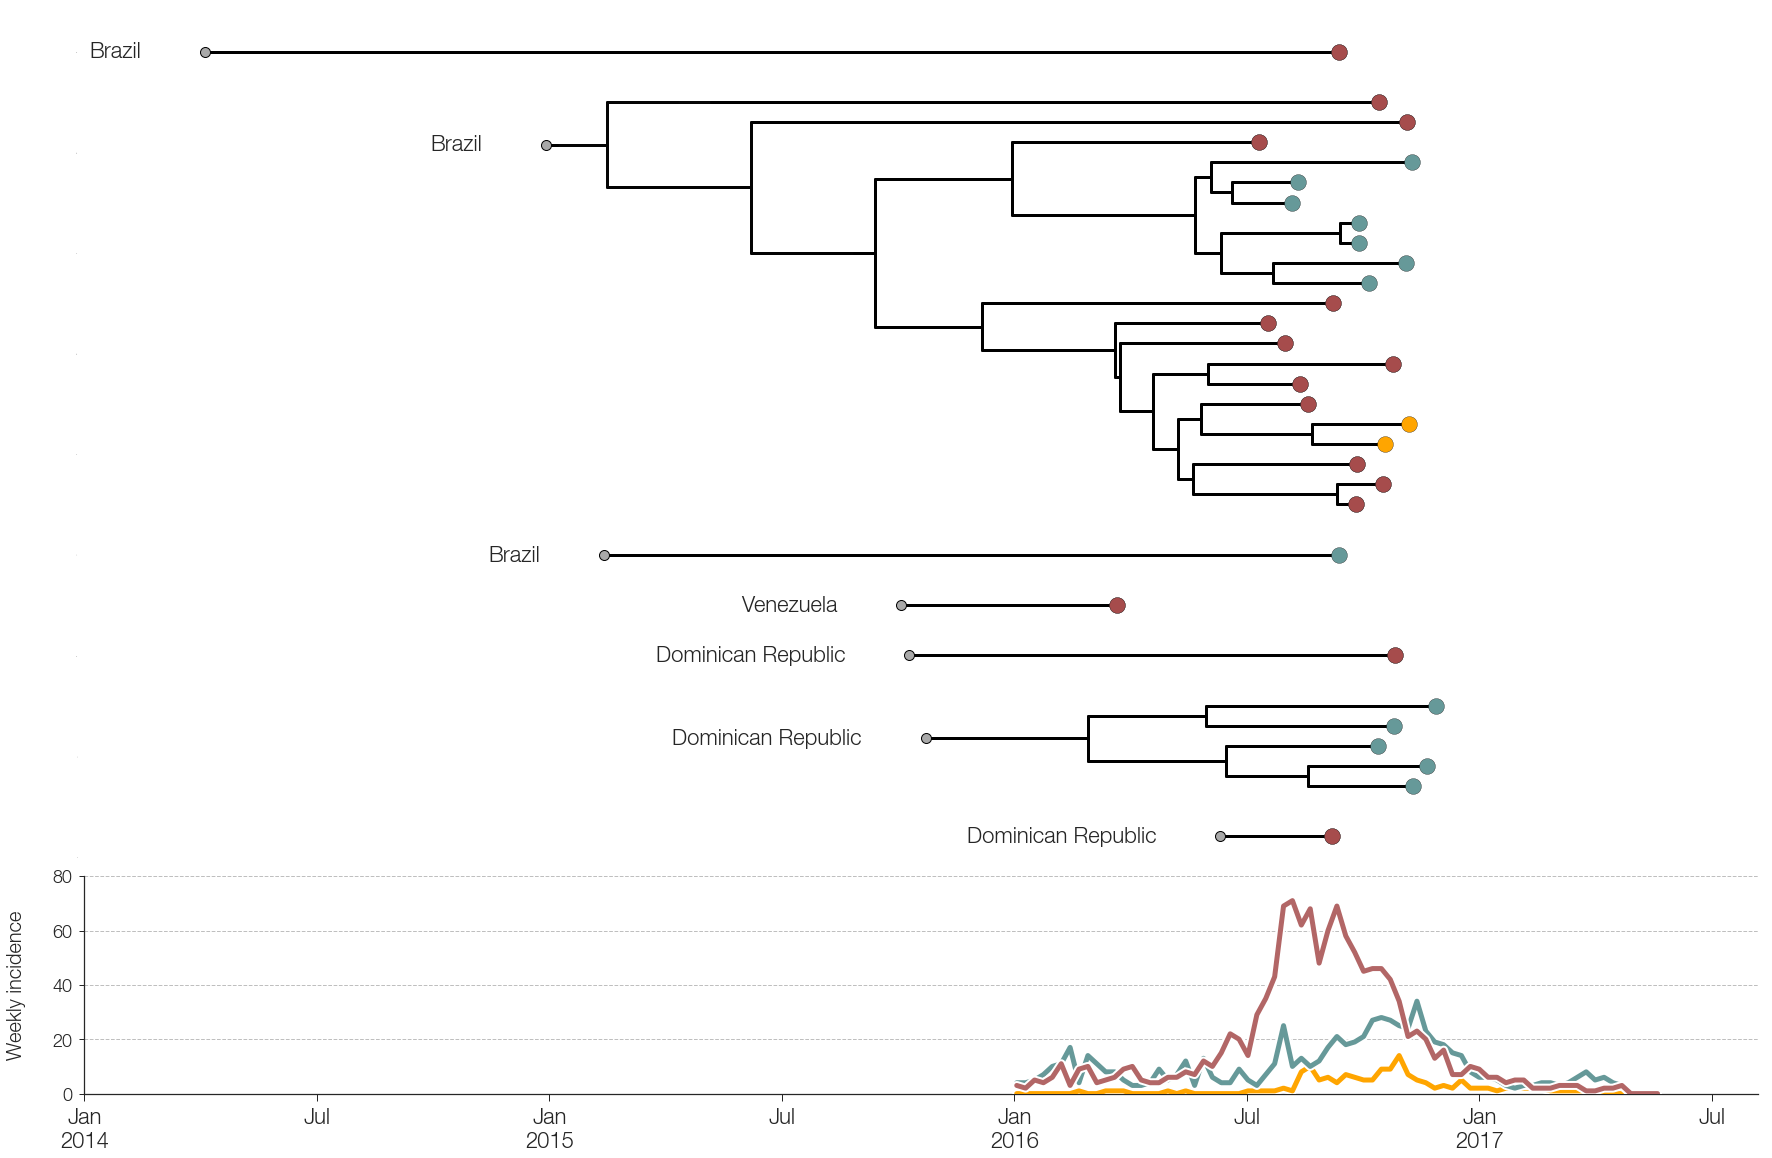

In [1442]:
#print within_country_trees['united_states_virgin_islands']
#print subtree_sizes['united_states_virgin_islands']
usvi_island_colors = {'saint_croix': '#669999', 'saint_thomas': 'maroon' ,'saint_john': 'orange'}
import matplotlib.patheffects as path_effects

#usvi_island_colors = {'saint_croix': 'maroon', 'saint_thomas': '#669999' ,'saint_john': '#003333'}
labeling_dict = {'dominican_republic':'Dominican Republic', 'brazil': 'Brazil', 'venezuela': 'Venezuela'}

colorbarTextSize=30 ## add colourbars
colorbarTickLabelSize=24
colorbarWidth=0.02
colorbarHeight=0.4
colorbarIncrement=0.08

#ax2 = fig.add_axes([colorbarIncrement*4, 0.13, colorbarHeight, colorbarWidth]) ## add dummy axes
#mpl.colorbar.ColorbarBase(ax2, cmap=mpl.cm.Greys,orientation='horizontal')
#color_map = [mpl.cm.Greys(x) for x in np.linspace(0.0,1.0,10)])

#####

gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1], wspace=0, hspace=0 )

fig = plt.subplots(figsize=(30,20),facecolor='w')

branchWidth=3 ## default branch width
tipSize = 250

ax = plt.subplot(gs[0])
cumulative_y = 0
#for origin,subtree in within_country_trees['united_states_virgin_islands']: #iterating over introductions to the USVI
#for origin,subtree in sorted(within_country_trees['united_states_virgin_islands'],key=lambda x: (len(x[1].leaves), x[1].root.absoluteTime),reverse=True):
for origin,subtree in sorted(within_country_trees['united_states_virgin_islands'],key=lambda x: (x[1].root.absoluteTime,len(x[1].leaves)),reverse=True):
    for k in subtree.Objects:
        x = k.absoluteTime
        y = k.y
        if k.parent.x == None:
            xp = x
        else:  
            xp = k.parent.absoluteTime

        #branch_color='lightgrey'
        branch_color = mpl.cm.Greys(k.traits['country.prob'])
        
        if isinstance(k,bt.leaf): ## leaves have circles at tips
            island = usvi_specific_island[k.name.split('|')[0]]
            color = usvi_island_colors[island]
            if island == 'saint_thomas':
                ax.scatter(x,y+cumulative_y,s=tipSize,facecolor='white', alpha=1,edgecolor='black',zorder=99)
                ax.scatter(x,y+cumulative_y,s=tipSize,facecolor=color, alpha=0.7,edgecolor='black',zorder=100) ## plot tip circle
            else:
                ax.scatter(x,y+cumulative_y,s=tipSize,facecolor=color, alpha=1.0,edgecolor='black',zorder=100) ## plot tip circle
            #ax.scatter(x,y+cumulative_y,s=tipSize+50,facecolor='k',edgecolor='none',zorder=99)

        elif isinstance(k,bt.node): ## nodes have vertical lines
            child1_y=k.children[0].y
            child2_y=k.children[-1].y
            ax.plot([x,x],[child1_y+cumulative_y,child2_y+cumulative_y],color=branch_color,lw=branchWidth,zorder=98) ## plot vertical bar 
        ax.plot([x,xp],[y+cumulative_y,y+cumulative_y],color=branch_color,lw=branchWidth,zorder=98) ## plot branch
    
    min_node_x = min(k.absoluteTime for k in subtree.Objects)        
    origin_color='darkgrey'
                  
    if subtree.Objects[0].absoluteTime==None:
        origin_prob = subtree.Objects[0].traits['country.prob']
        origin_x=subtree.Objects[0].absoluteTime #sending country has same x coord as root in receiving country.
        origin_y=subtree.Objects[0].y+cumulative_y #and same for the y coordinates
    else:
        origin_prob = subtree.Objects[0].traits['country.prob']
        origin_x=subtree.Objects[0].parent.absoluteTime
        origin_y=subtree.Objects[0].y+cumulative_y

    if origin!='ancestor': ## add text if not dealing with the very first introduction into the americas
        ax.text(origin_x-50/365.0,origin_y,'{}'.format(labeling_dict[origin]),ha='right',va='center', size=22) #label origin country
        #ax.text(origin_x-30/365.0,origin_y-1.5,'posterior: {0:.2f}'.format(origin_prob),ha='right',va='center', size=18)
        ax.scatter(origin_x,origin_y,100,facecolor=origin_color,edgecolor='black',lw=1,zorder=200) ## circle at the base of the subtree to indicate origin
        ax.plot([min_node_x,origin_x],[origin_y,origin_y],color=branch_color,lw=branchWidth,zorder=98)
        
    cumulative_y += max([x.y for x in subtree.Objects])+1.5 ## increment y position

#Remove lines from sides of plot that I don't like
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
#ax.set_xticks([2014.0, 2014.5, 2015.0, 2015.5, 2016.0, 2016.5, 2017.0, 2017.5, 2018.0 ])
ax.set_xticklabels([])


ax.tick_params(axis='y',labelsize=0,size=0)
ax.tick_params(axis='top',labelsize=0,size=0)
ax.tick_params(axis='bottom',labelsize=0,size=0)

ax.set_xlim(2014,2017.6)
#ax.set_ylabel('Introductions to USVI, by island',size=20)

'''ax.axvline(2014.0,ls='--',color='grey', linewidth = 1, alpha = 0.5)
ax.axvline(2015.0,ls='--',color='grey', linewidth = 1, alpha = 0.5)
ax.axvline(2016.0,ls='--',color='grey', linewidth = 1, alpha = 0.5)
ax.axvline(2017.0,ls='--',color='grey', linewidth = 1, alpha = 0.5)
ax.axvline(2018.0,ls='--',color='grey', linewidth = 1, alpha = 0.5)'''

#labels = [2014.0, 2014.5, 2015.0, 2015.5, 2016.0, 2016.5, 2017.0, 2017.5, 2018.0 ]
#ax.set_xticklabels([decimalDateToAxisLabel(label) for label in labels])


'''ax.scatter(2014.08,25,s=400,facecolor=usvi_island_colors['saint_croix'],edgecolor='black',zorder=10) ## 
ax.scatter(2014.08,22,s=400,facecolor='white', alpha = 1, edgecolor='black',zorder=9) ## 
ax.scatter(2014.08,22,s=400,facecolor=usvi_island_colors['saint_thomas'], alpha = 0.7, edgecolor='black',zorder=10) ## plot white circle underneath bc alpha is low
ax.scatter(2014.08,19,s=400,facecolor=usvi_island_colors['saint_john'],edgecolor='black',zorder=10) 

ax2.text(2014,24.5, 'Saint Thomas', size=40, color=usvi_island_colors['saint_thomas'],alpha=0.8)
ax2.text(2014,21.5, 'Saint Croix', size=40, color=usvi_island_colors['saint_croix'])
ax2.text(2014,18.5, 'Saint John', size=40, color=usvi_island_colors['saint_john'])
'''

# effects=[path_effects.Stroke(linewidth=0.5, foreground='white'),path_effects.Stroke(linewidth=0.5, foreground='black')]

# ax.text(2014.,26, 'Saint Thomas', size=50, color=usvi_island_colors['saint_thomas'],alpha=0.8, path_effects=effects)
# ax.text(2014.,22, 'Saint Croix', size=50, color=usvi_island_colors['saint_croix'],path_effects=effects)
# ax.text(2014.,18, 'Saint John', size=50, color=usvi_island_colors['saint_john'], path_effects=effects)

#timeline = np.arange(2014, 2018.0833333333333, 0.08333333333333333)
#[ax.axvspan(timeline[i],timeline[i+1],facecolor='k',edgecolor='none',alpha=0.04) for i in range(0,len(timeline)-1,2)]


#### 2nd panel: incidence

ax2 = plt.subplot(gs[1])
islands = ['saint_croix', 'saint_thomas', 'saint_john']

for island in islands:
    x_values = [decimalDate(x) for x in usvi_df['date']]
    y_values = [y for y in usvi_df[island]]
    
    if island == 'saint_thomas':
        ax2.plot(x_values,y_values,color=usvi_island_colors[island], alpha = 0.6,lw=5,label='x',zorder=int(sum(y_values)))
    else:
        ax2.plot(x_values,y_values,color=usvi_island_colors[island], alpha = 1,lw=5,label='x',zorder=int(sum(y_values)))
    ax2.plot(x_values,y_values,color='w',lw=9,zorder=int(sum(y_values))-1)

ax2.set_xlim(2014,2017.6)

default_ticks = ax2.get_xticks()
ax2.set_xticklabels([decimalDateToAxisLabel(x) for x in default_ticks])

ax2.set_ylabel('Weekly incidence\n',size=20)
ax2.set_ylim(0,80)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

ax2.tick_params(axis='x',labelsize=22, which='major', width=1, size=7)
ax2.tick_params(axis='y',labelsize=18, width=1, size=5)

'''ax2.axvline(2014.0,ls='--',color='grey', linewidth = 1, alpha = 0.5)
ax2.axvline(2015.0,ls='--',color='grey', linewidth = 1, alpha = 0.5)
ax2.axvline(2016.0,ls='--',color='grey', linewidth = 1, alpha = 0.5)
ax2.axvline(2017.0,ls='--',color='grey', linewidth = 1, alpha = 0.5)
ax2.axvline(2018.0,ls='--',color='grey', linewidth = 1, alpha = 0.5)'''


ax2.axhline(20,ls='--',color='grey', linewidth = 1, alpha = 0.5)
ax2.axhline(40,ls='--',color='grey', linewidth = 1, alpha = 0.5)
ax2.axhline(60,ls='--',color='grey', linewidth = 1, alpha = 0.5)
ax2.axhline(80,ls='--',color='grey', linewidth = 1, alpha = 0.5)
'''
effects=[path_effects.Stroke(linewidth=0.5, foreground='white'),path_effects.Stroke(linewidth=0.5, foreground='black')]

ax2.text(2014.1,61, 'Saint Thomas', size=50, color=usvi_island_colors['saint_thomas'],alpha=0.8, path_effects=effects)
ax2.text(2014.1,41, 'Saint Croix', size=50, color=usvi_island_colors['saint_croix'],path_effects=effects)
ax2.text(2014.1,21, 'Saint John', size=50, color=usvi_island_colors['saint_john'], path_effects=effects)
#ax2.axvline(decimalDate('2016-01-20'),ls='--',color='grey', linewidth = 1, alpha = 0.5)
'''

#[ax2.axvspan(timeline[i],timeline[i+1],facecolor='k',edgecolor='none',alpha=0.04) for i in range(0,len(timeline)-1,2)]

plt.savefig('/Users/alliblk/Desktop/gitrepos/zika-usvi/figures/usvi_introductions_and_incidence_transparent.png', transparent=True)
plt.savefig('/Users/alliblk/Desktop/gitrepos/zika-usvi/figures/usvi_introductions_and_incidence_transparent.pdf', transparent=True)

(735938.05000000005, 736497.94999999995)
(735938.05000000005, 736497.94999999995)


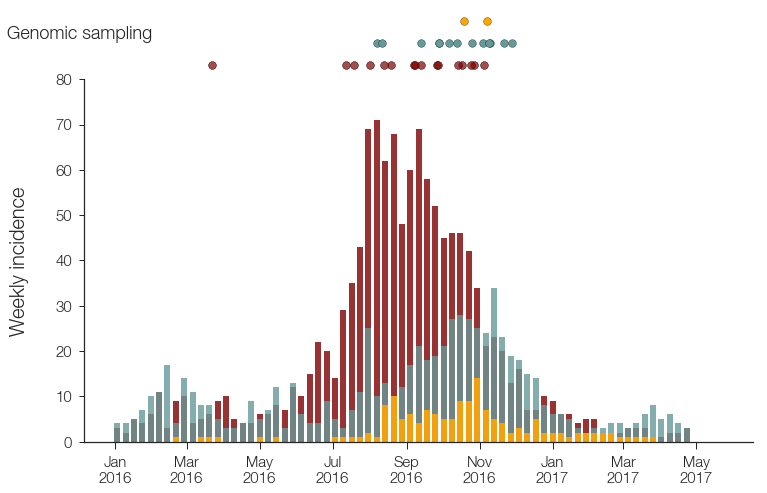

In [1433]:
from matplotlib.dates import DateFormatter, DayLocator, YearLocator

gs = gridspec.GridSpec(2, 1, height_ratios=[1, 5], wspace=0, hspace=0 )

fig,ax = plt.subplots(figsize=(12, 8),facecolor='w')

ax = plt.subplot(gs[1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
#ax.spines['bottom'].set_visible(False)

dates = [dt.strptime(x,'%Y-%m-%d') for x in usvi_df['date']]

saint_john_cases = usvi_df['saint_john']
saint_thomas_cases = usvi_df['saint_thomas']
saint_croix_cases = usvi_df['saint_croix']
 
plt.bar(dates, saint_thomas_cases, align='center', width = 5, alpha=0.8, color=usvi_island_colors['saint_thomas'])
plt.bar(dates, saint_croix_cases, align='center', width = 5, alpha=0.8, color=usvi_island_colors['saint_croix'])
plt.bar(dates, saint_john_cases, align='center', width = 5, alpha=0.9, color=usvi_island_colors['saint_john'])

ax.xaxis_date()
weekFormatter = DateFormatter('%b\n%Y')              
ax.xaxis.set_major_formatter(weekFormatter)

ax.set_ylabel('Weekly incidence\n',size=20)
ax.set_ylim(0,80)
#ax.set_xlim(-8, 70)

ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(False)

ax.tick_params(axis='x',labelsize=15, width=1, size=7)
ax.tick_params(axis='y',labelsize=15, width=1, size=5)

print(ax.get_xlim())

# ax.scatter(dt.strptime('2017-03-01','%Y-%m-%d'),75,s=800,facecolor=usvi_island_colors['saint_john'],marker="_", linewidth=4) 
# ax.scatter(dt.strptime('2017-03-01','%Y-%m-%d'),68,s=800,facecolor=usvi_island_colors['saint_croix'], marker="_", linewidth=4) ## 
# ax.scatter(dt.strptime('2017-03-01','%Y-%m-%d'),61,s=800,facecolor=usvi_island_colors['saint_thomas'],marker="_", alpha=0.8, linewidth=4) ## plot white circle underneath bc alpha is low

# ax.text(dt.strptime('2017-03-20','%Y-%m-%d'),73, 'Saint John', size=18)
# ax.text(dt.strptime('2017-03-20','%Y-%m-%d'),66, 'Saint Croix', size=18)
# ax.text(dt.strptime('2017-03-20','%Y-%m-%d'),59, 'Saint Thomas', size=18)

### GENOMES

ax2 = plt.subplot(gs[0])

for origin,subtree in sorted(within_country_trees['united_states_virgin_islands'],key=lambda x: (x[1].root.absoluteTime,len(x[1].leaves)),reverse=True):
    for k in subtree.Objects:
        if isinstance(k,bt.leaf): ## leaves have circles at tips
            date = dt.strptime(k.name.split('|')[1],'%Y-%m-%d')
            island = usvi_specific_island[k.name.split('|')[0]]
            color = usvi_island_colors[island]
            
            if island == 'saint_thomas':
                ax2.scatter(date,0.2,s=60,facecolor='white', alpha=1,edgecolor='black',zorder=99)
                ax2.scatter(date,0.2,s=60,facecolor=color, alpha=0.7,edgecolor='black',zorder=100) ## plot tip circle
            elif island == 'saint_croix':
                ax2.scatter(date,0.5,s=60,facecolor=color, alpha=1.0,edgecolor='black',zorder=100) ## plot tip circle
            elif island == 'saint_john':
                ax2.scatter(date,0.8,s=60,facecolor=color, alpha=1.0,edgecolor='black',zorder=100) 

ax2.xaxis_date()
ax2.set_ylim(0,1)
ax2.set_xlim(735938.05000000005, 736497.94999999995)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

ax2.set_ylabel('Genomic sampling', rotation = 360, size=18)
ax2.set_xticks([])
ax2.set_yticks([])
print(ax2.get_xlim())

    
plt.savefig('/Users/alliblk/Desktop/gitrepos/zika-usvi/figures/epi_curve_usvi_transparent.pdf', transparent = True)

[ 735964.  736024.  736085.  736146.  736208.  736269.  736330.  736389.
  736450.]
[ 735900.  736000.  736100.  736200.  736300.  736400.  736500.]


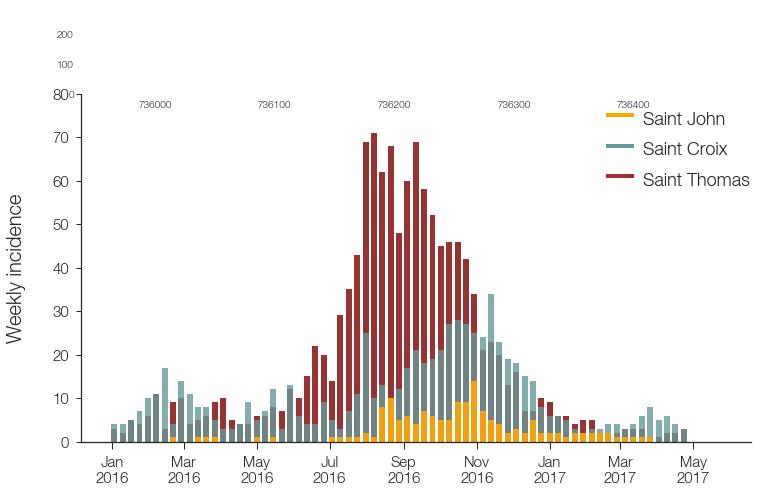

In [1391]:
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 4], wspace=0, hspace=0 )

fig,ax = plt.subplots(figsize=(12, 8),facecolor='w')

ax = plt.subplot(gs[1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
#ax.spines['bottom'].set_visible(False)

dates = [dt.strptime(x,'%Y-%m-%d') for x in usvi_df['date']]

saint_john_cases = usvi_df['saint_john']
saint_thomas_cases = usvi_df['saint_thomas']
saint_croix_cases = usvi_df['saint_croix']
 
plt.bar(dates, saint_thomas_cases, align='center', width = 5, alpha=0.8, color=usvi_island_colors['saint_thomas'])
plt.bar(dates, saint_croix_cases, align='center', width = 5, alpha=0.8, color=usvi_island_colors['saint_croix'])
plt.bar(dates, saint_john_cases, align='center', width = 5, alpha=0.9, color=usvi_island_colors['saint_john'])

ax.xaxis_date()
weekFormatter = DateFormatter('%b\n%Y')              
ax.xaxis.set_major_formatter(weekFormatter)

ax.set_ylabel('Weekly incidence\n',size=20)
ax.set_ylim(0,80)
#ax.set_xlim(-8, 70)

ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(False)

ax.tick_params(axis='x',labelsize=15, width=1, size=7)
ax.tick_params(axis='y',labelsize=15, width=1, size=5)

#print(ax.get_xlim())
print ax.get_xticks()

ax.scatter(dt.strptime('2017-03-01','%Y-%m-%d'),75,s=800,facecolor=usvi_island_colors['saint_john'],marker="_", linewidth=4) 
ax.scatter(dt.strptime('2017-03-01','%Y-%m-%d'),68,s=800,facecolor=usvi_island_colors['saint_croix'], marker="_", linewidth=4) ## 
ax.scatter(dt.strptime('2017-03-01','%Y-%m-%d'),61,s=800,facecolor=usvi_island_colors['saint_thomas'],marker="_", alpha=0.8, linewidth=4) ## plot white circle underneath bc alpha is low

ax.text(dt.strptime('2017-03-20','%Y-%m-%d'),73, 'Saint John', size=18)
ax.text(dt.strptime('2017-03-20','%Y-%m-%d'),66, 'Saint Croix', size=18)
ax.text(dt.strptime('2017-03-20','%Y-%m-%d'),59, 'Saint Thomas', size=18)

ax2 = plt.subplot(gs[0])
counter = 0
yposition = 5

for origin,subtree in sorted(within_country_trees_SB['united_states_virgin_islands'],key=lambda x: (x[1].root.absoluteTime,len(x[1].leaves)),reverse=True):
    for k in subtree.Objects:
        if isinstance(k,bt.leaf): ## leaves have circles at tips
            date = dt.strptime(k.name.split('|')[1],'%Y-%m-%d')
            color = usvi_island_colors[island]
            
            if island == 'saint_thomas':
                ax2.scatter(date,0.2,s=60,facecolor='white', alpha=1,edgecolor='black',zorder=99)
                ax2.scatter(date,0.2,s=60,facecolor=color, alpha=0.7,edgecolor='black',zorder=100) ## plot tip circle
            elif island == 'saint_croix':
                ax2.scatter(date,0.5,s=60,facecolor=color, alpha=1.0,edgecolor='black',zorder=100) ## plot tip circle
            elif island == 'saint_john':
                ax2.scatter(date,0.8,s=60,facecolor=color, alpha=1.0,edgecolor='black',zorder=100) 

ax2.xaxis_date()
ax2.set_ylim(0,1)
ax2.set_xlim(735938.05000000005, 736497.94999999995)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)


    yposition += 15

    counter += 1
    #Remove lines from sides of plot that I don't like
#ax2.plot(x_values, usvi_df['total_cases'], ls='--', lw=4, color='darkgrey')

#ax2.xaxis_date()
ax2.set_ylim(0,290)
ax2.set_xlim(735938.05000000005, 736497.94999999995)

#ax2.set_xlim(dt.strptime('2014-1-1','%Y-%m-%d'), dt.strptime('2017-1-1','%Y-%m-%d'))
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax.xaxis_date()
print ax2.get_xticks()

#default_ticks = ax2.get_xticks()
#ax2.set_xticklabels([decimalDateToAxisLabel(x) for x in default_ticks])

#ax2.tick_params(axis='x',labelsize=22, which='major', width=1, size=7)
#ax2.tick_params(axis='y',labelsize=0, which='major', width=0, size=0)
plt.show()

In [1154]:
#Import skygrid reconstruction. Values are already exponentiated (tracer does this when you do the reconstruction)
skygrid_df = pd.read_csv('/Users/alliblk/Desktop/gitrepos/zika-usvi/beast/usvi-only/usvi_only_demogRecon_timeSet.tsv', comment='#', sep='\t')
skygrid_df

#estimated serial interval for Zika
tau_in_days = 15 #From Majumder et al 2016 
tau_in_years = tau_in_days/365.25
#print tau_in_years

duration_of_infection = 9.9 #amount of time virus is detectable in blood, from Lessler et al, 2016.
#AT STEADY STATE: incidence = prevalence/duration of disease. Ne is effective prevalence, try to get incidence
#attempt at comparaiblity with case surveillance stuff.


#Ne approximates PERIOD PREVALENCE (inclues new and preexisting cases)
skygrid_df['median_ne'] = skygrid_df['Median'].apply(lambda x: x/tau_in_years)
skygrid_df['upper_ne'] = skygrid_df['Upper'].apply(lambda x: x/tau_in_years)
skygrid_df['lower_ne'] = skygrid_df['Lower'].apply(lambda x: x/tau_in_years)
skygrid_df

#Rough estimates of incidence
skygrid_df['median_incidence'] = skygrid_df['median_ne'].apply(lambda x: x/duration_of_infection)
skygrid_df['upper_incidence'] = skygrid_df['upper_ne'].apply(lambda x: x/duration_of_infection)
skygrid_df['lower_incidence'] = skygrid_df['lower_ne'].apply(lambda x: x/duration_of_infection)
skygrid_df
#skygrid_df.to_csv('/Users/alliblk/Desktop/gitrepos/zika-usvi/data/NeTau_estimates.tsv', sep='\t')

,Time,Mean,Median,Upper,Lower,median_ne,upper_ne,lower_ne,median_incidence,upper_incidence,lower_incidence
0,2016.907104,7.754738,6.271045,129.956007,1.001855,152.699937,3164.428780,24.395166,15.424236,319.639271,2.464158
1,2016.828156,7.872462,6.382596,60.604947,1.340265,155.416220,1475.730448,32.635450,15.698608,149.063682,3.296510
2,2016.749209,6.582221,5.885870,29.261480,1.834989,143.320930,712.517028,44.681984,14.476862,71.971417,4.513332
3,2016.670262,5.348539,4.891350,19.988545,1.490240,119.104361,486.721065,36.287345,12.030744,49.163744,3.665388
4,2016.591314,4.368721,4.076670,15.120728,1.465055,99.266912,368.189722,35.674095,10.026961,37.190881,3.603444
5,2016.512367,3.107609,2.865966,8.694144,1.040493,69.786278,211.702412,25.336017,7.049119,21.384082,2.559194
6,2016.433420,1.844423,1.809803,6.889262,0.587561,44.068701,167.753536,14.307106,4.451384,16.944802,1.445162
7,2016.354472,1.213497,1.247866,3.444929,0.393784,30.385526,83.884032,9.588652,3.069245,8.473135,0.968551
8,2016.275525,1.226603,1.245480,3.832271,0.372655,30.327436,93.315788,9.074139,3.063377,9.425837,0.916580
9,2016.196578,1.337386,1.306742,3.833652,0.418757,31.819159,93.349424,10.196724,3.214056,9.429235,1.029972


In [1181]:
usvi_df
usvi_df['total_cases'] = usvi_df['saint_thomas'] + usvi_df['saint_croix'] + usvi_df['saint_john']
usvi_df

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,date,saint_thomas,saint_croix,saint_john,decimal_date,total_cases
0,2016-01-03,3,4,0,2016.005464,7
1,2016-01-10,2,4,0,2016.024590,6
2,2016-01-17,5,5,0,2016.043716,10
3,2016-01-24,4,7,0,2016.062842,11
4,2016-01-31,6,10,0,2016.081967,16
5,2016-02-07,11,11,0,2016.101093,22
6,2016-02-14,3,17,0,2016.120219,20
7,2016-02-21,9,4,1,2016.139344,14
8,2016-02-28,10,14,0,2016.158470,24
9,2016-03-06,4,11,0,2016.177596,15


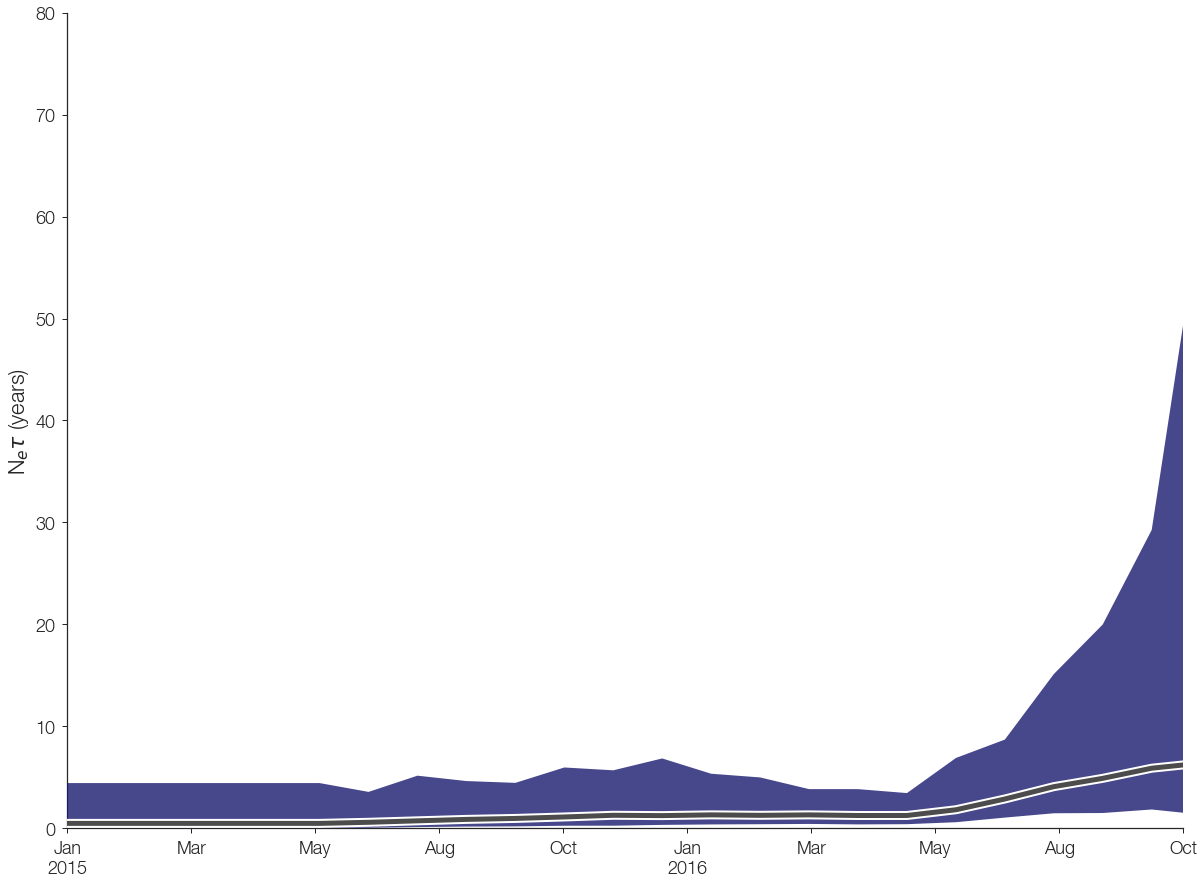

In [1151]:
fig,ax = plt.subplots(figsize=(20, 15),facecolor='w')

ax.set_ylim(0,80)
ax.set_xlim(2015.,2016.8)

#plot median and HPD for NeTau
ax.plot(skygrid_df['Time'], skygrid_df['Median'], color='black',lw=5, zorder=20000, alpha =0.7)
ax.plot(skygrid_df['Time'], skygrid_df['Median'],color='w',lw=9,zorder=19998)
ax.fill_between(x=skygrid_df['Time'], y1=skygrid_df['Lower'], y2=skygrid_df['Upper'], facecolor='midnightblue',zorder=100, alpha=0.8)

ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.set_ylabel(r'N$_{e}\tau$ (years)',size=22)

ax.tick_params(axis='x',size=5,labelsize=18,direction='out')
ax.tick_params(axis='y',size=5,labelsize=18,direction='out')

default_ticks = ax.get_xticks()
ax.set_xticklabels([decimalDateToAxisLabel(x) for x in default_ticks])

plt.savefig('/Users/alliblk/Desktop/gitrepos/zika-usvi/figures/usvi_skylinePlot.pdf', transparent=True)

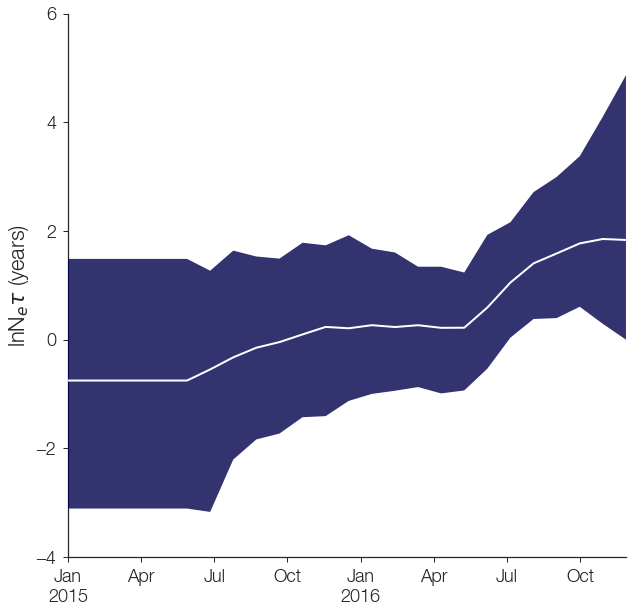

In [896]:
fig,ax = plt.subplots(figsize=(10, 10),facecolor='w') 

ax.set_ylim(-4,6)
ax.set_xlim(2015.,max(skygrid_df['Time']))

#plot ln(median) and ln(NeTau)
ln_median = np.log(skygrid_df['Median'])
ln_upper = np.log(skygrid_df['Upper'])
ln_lower = np.log(skygrid_df['Lower'])
ax.plot(skygrid_df['Time'],ln_median, color='white', lw=2, zorder=199)
ax.fill_between(x=skygrid_df['Time'], y1=ln_lower, y2=ln_upper, facecolor='#00004C',zorder=100, alpha=0.8)


ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.set_ylabel(r'lnN$_{e}\tau$ (years)',size=22)

ax.tick_params(axis='x',size=5,labelsize=18,direction='out')
ax.tick_params(axis='y',size=5,labelsize=18,direction='out')

default_ticks = ax.get_xticks()
ax.set_xticklabels([decimalDateToAxisLabel(x) for x in default_ticks])

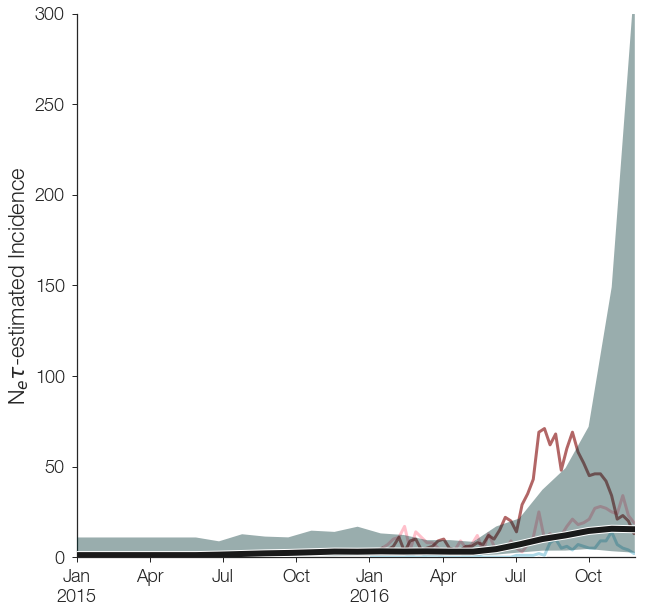

In [926]:
fig,ax2 = plt.subplots(figsize=(10, 10),facecolor='w')

ax2.set_ylim(0,300)
ax2.set_xlim(2015.,max(skygrid_df['Time']))


for island in islands:
    x_values = [decimalDate(x) for x in usvi_df['date']]
    y_values = [y for y in usvi_df[island]]
    
    if island == 'saint_thomas':
        ax2.plot(x_values,y_values,color=usvi_island_colors[island], alpha = 0.6,lw=3,label='x',zorder=20)
    else:
        ax2.plot(x_values,y_values,color=usvi_island_colors[island], alpha = 1,lw=3,label='x',zorder=20)
    ax2.plot(x_values,y_values,color='w',lw=5,zorder=19)
    
    
#INCIDENCE
#hpd_color = '#669999'
hpd_color = '#003333'
#hpd_color = 'lightgrey'
ax2.plot(skygrid_df['Time'], skygrid_df['median_incidence'], color='black',lw=6, zorder=202, alpha =0.9)
ax2.plot(skygrid_df['Time'], skygrid_df['median_incidence'],color='w',lw=8,zorder=201)
ax2.fill_between(x=skygrid_df['Time'], y1=skygrid_df['lower_incidence'], y2=skygrid_df['upper_incidence'], facecolor=hpd_color, zorder=100, alpha=0.4)



    

ax2.xaxis.tick_bottom()
ax2.yaxis.tick_left()

ax2.spines['right'].set_color('none')
ax2.spines['top'].set_color('none')

ax2.set_ylabel(r'N$_{e}\tau$-estimated Incidence',size=22)

ax2.tick_params(axis='x',size=5,labelsize=18,direction='out')
ax2.tick_params(axis='y',size=5,labelsize=18,direction='out')

default_ticks = ax2.get_xticks()
ax2.set_xticklabels([decimalDateToAxisLabel(x) for x in default_ticks])

plt.savefig('/Users/alliblk/Desktop/gitrepos/zika-usvi/figures/usvi_netau_incidence_transparent.pdf',transparent=True)

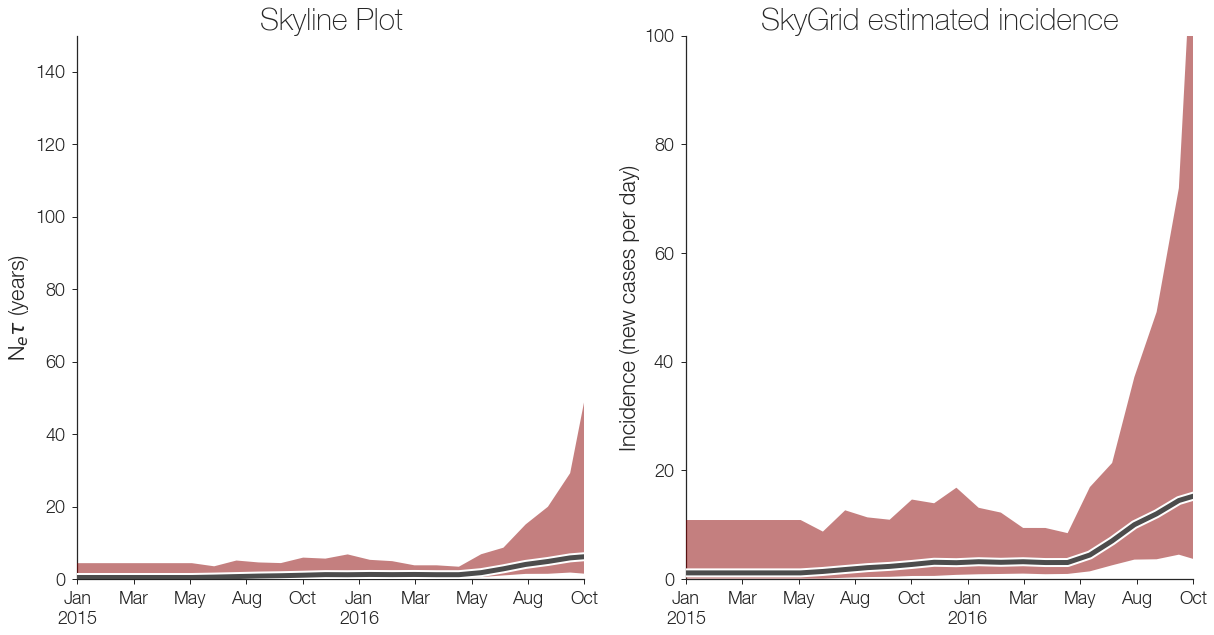

In [1141]:
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.2, hspace=0 )

fig,ax = plt.subplots(figsize=(20, 15),facecolor='w')

##PANEL 1
ax = plt.subplot(gs[0])
ax.set_ylim(0,150)
ax.set_xlim(2015.,2016.8)

#plot median and HPD for NeTau
ax.plot(skygrid_df['Time'], skygrid_df['Median'], color='black',lw=5, zorder=20000, alpha =0.7)
ax.plot(skygrid_df['Time'], skygrid_df['Median'],color='w',lw=9,zorder=19998)
ax.fill_between(x=skygrid_df['Time'], y1=skygrid_df['Lower'], y2=skygrid_df['Upper'], facecolor='darkred',zorder=100, alpha=0.8)

ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.set_ylabel(r'N$_{e}\tau$ (years)',size=22)

ax.tick_params(axis='x',size=5,labelsize=18,direction='out')
ax.tick_params(axis='y',size=5,labelsize=18,direction='out')

default_ticks = ax.get_xticks()
ax.set_xticklabels([decimalDateToAxisLabel(x) for x in default_ticks])

ax.set_title('Skyline Plot', size=30)


##### Panel 2


ax2 = plt.subplot(gs[1])

ax2.set_ylim(0,100)
ax2.set_xlim(2015.,2016.8)

#INCIDENCE
ax2.plot(skygrid_df['Time'], skygrid_df['median_incidence'], color='black',lw=5, zorder=20000, alpha =0.7)
ax2.plot(skygrid_df['Time'], skygrid_df['median_incidence'],color='w',lw=9,zorder=19998)
ax2.fill_between(x=skygrid_df['Time'], y1=skygrid_df['lower_incidence'], y2=skygrid_df['upper_incidence'], facecolor='midnightblue',zorder=100, alpha=0.5)

'''
for island in islands:
    x_values = [decimalDate(x) for x in usvi_df['date']]
    y_values = [y for y in usvi_df[island]]
    
    if island == 'saint_thomas':
        ax2.plot(x_values,y_values,color=usvi_island_colors[island], alpha = 0.5,lw=3,label='x',zorder=int(sum(y_values)))
    else:
        ax2.plot(x_values,y_values,color=usvi_island_colors[island], alpha = 0.7,lw=3,label='x',zorder=int(sum(y_values)))
    ax2.plot(x_values,y_values,color='w',lw=5,zorder=int(sum(y_values))-1)
    '''

ax2.xaxis.tick_bottom()
ax2.yaxis.tick_left()

ax2.spines['right'].set_color('none')
ax2.spines['top'].set_color('none')
ax2.set_ylabel('Incidence (new cases per day)', size=22)

ax2.set_title('SkyGrid estimated incidence',size=30)

ax2.tick_params(axis='x',size=5,labelsize=18,direction='out')
ax2.tick_params(axis='y',size=5,labelsize=18,direction='out')

default_ticks = ax2.get_xticks()
ax2.set_xticklabels([decimalDateToAxisLabel(x) for x in default_ticks])

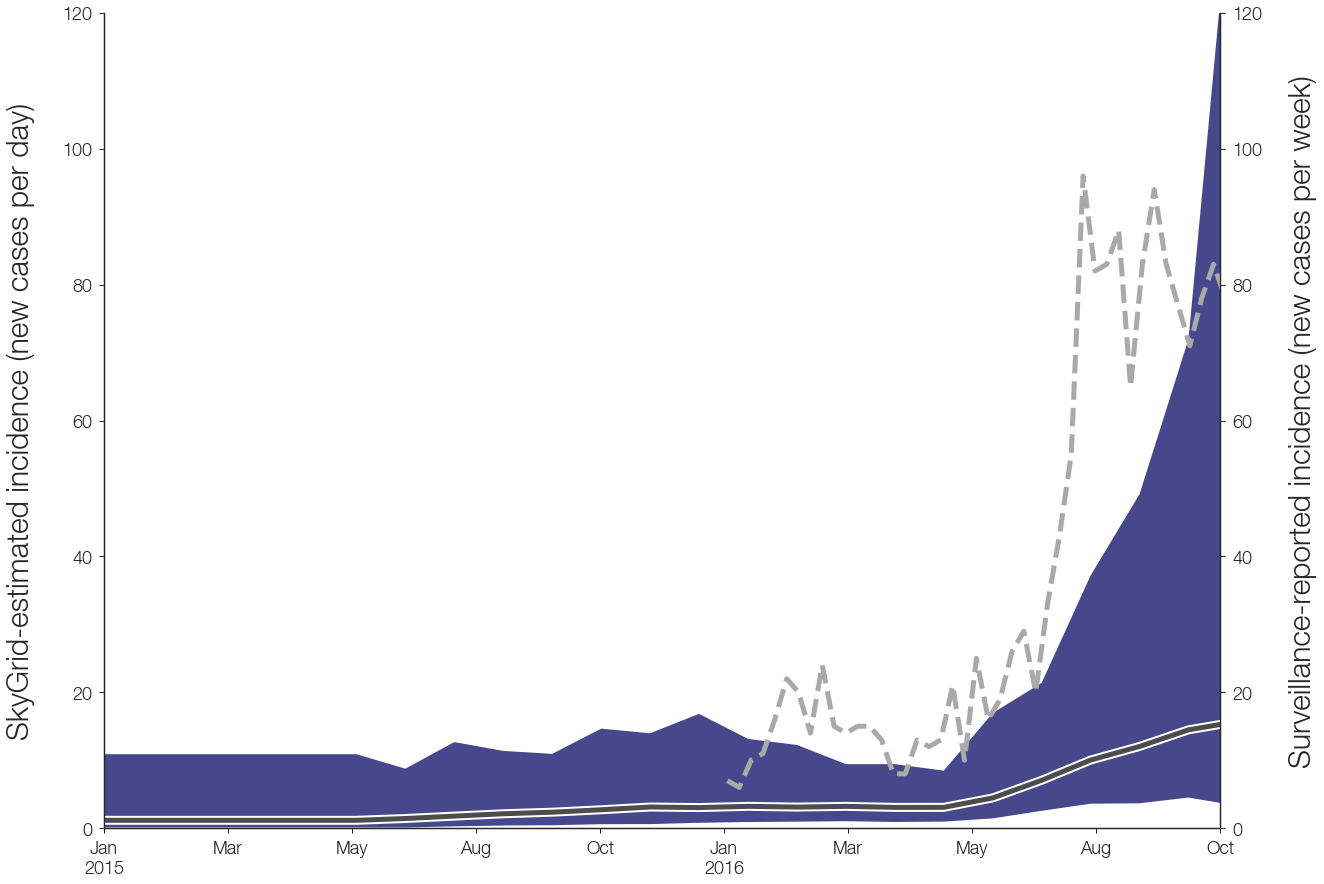

In [1192]:
#INCIDENCE
fig,ax = plt.subplots(figsize=(20, 15),facecolor='w')

ax2 = ax.twinx()

'''for island in islands:
    x_values = [decimalDate(x) for x in usvi_df['date']]
    y_values = [y for y in usvi_df[island]]
    
    if island == 'saint_thomas':
        ax.plot(x_values,y_values,color=usvi_island_colors[island], alpha = 0.5,lw=3,label='x',zorder=int(sum(y_values)))
    else:
        ax.plot(x_values,y_values,color=usvi_island_colors[island], alpha = 0.7,lw=3,label='x',zorder=int(sum(y_values)))
    ax.plot(x_values,y_values,color='w',lw=5,zorder=int(sum(y_values))-1)
'''
x_values = [decimalDate(x) for x in usvi_df['date']]
ax2.plot(x_values, usvi_df['total_cases'], ls='--', lw=5, color='darkgrey')

ax.plot(skygrid_df['Time'], skygrid_df['median_incidence'], color='black',lw=5, zorder=20000, alpha =0.7)
ax.plot(skygrid_df['Time'], skygrid_df['median_incidence'],color='w',lw=9,zorder=19998)
ax.fill_between(x=skygrid_df['Time'], y1=skygrid_df['lower_incidence'], y2=skygrid_df['upper_incidence'], facecolor='midnightblue',zorder=100, alpha=0.8)


ax.set_xlim(2015.,2016.8)

ax.set_ylim(0,120)
ax2.set_ylim(0,120)

ax2.yaxis.tick_left()
ax.yaxis.tick_right()

ax.xaxis.tick_bottom()
default_ticks = ax.get_xticks()
ax.set_xticklabels([decimalDateToAxisLabel(x) for x in default_ticks])
ax.tick_params(axis='x',size=5,labelsize=18,direction='out')
ax.tick_params(axis='y',size=5,labelsize=18,direction='out')

ax2.xaxis.tick_bottom()
default_ticks = ax2.get_xticks()
ax2.set_xticklabels([decimalDateToAxisLabel(x) for x in default_ticks])
ax2.tick_params(axis='x',size=5,labelsize=18,direction='out')
ax2.tick_params(axis='y',size=5,labelsize=18,direction='out')

ax.tick_params(axis='y',size=5,labelsize=18,direction='out')

ax.spines['top'].set_color('none')
ax.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax.set_ylabel('SkyGrid-estimated incidence (new cases per day)\n\n', size=30)
ax2.set_ylabel('\n\nSurveillance-reported incidence (new cases per week)', size = 30)
#ax2.set_title('SkyGrid estimated incidence',size=30)

ax2.tick_params(axis='x',size=5,labelsize=18,direction='out')
ax2.tick_params(axis='y',size=5,labelsize=18,direction='out')

plt.savefig('/Users/alliblk/Desktop/gitrepos/zika-usvi/figures/incidences.pdf', transparent=True)

In [1193]:
import vincent
world_countries = r'world-countries.json'
world = vincent.Map(width=1200, height=1000)
world.geo_data(projection='winkel3', scale=200, world=world_countries)
world.to_json(path)

ImportError: No module named vincent

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,date,saint_thomas,saint_croix,saint_john,decimal_date
0,2016-01-03,3,4,0,2016.005464
1,2016-01-10,2,4,0,2016.024590
2,2016-01-17,5,5,0,2016.043716
3,2016-01-24,4,7,0,2016.062842
4,2016-01-31,6,10,0,2016.081967
5,2016-02-07,11,11,0,2016.101093
6,2016-02-14,3,17,0,2016.120219
7,2016-02-21,9,4,1,2016.139344
8,2016-02-28,10,14,0,2016.158470
9,2016-03-06,4,11,0,2016.177596


2016.03005464


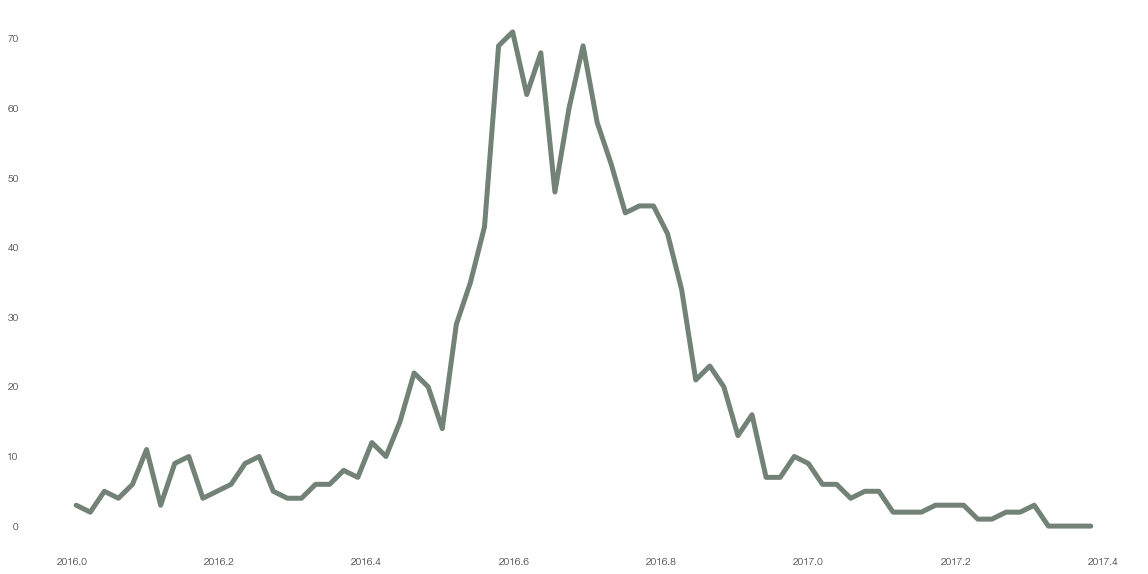

In [350]:
#incidence by itself

fig,ax = plt.subplots(figsize=(20, 10),facecolor='w')

islands = ['saint_croix', 'saint_thomas', 'saint_john']
island1 = ['saint_thomas']

for island in island1:
    x_values = [decimalDate(x) for x in usvi_df['date']]
    y_values = [y for y in usvi_df[island]]

    ax.plot(x_values,y_values,color='#738276',lw=5,label='x',zorder=int(sum(y_values)))
    ax.plot(x_values,y_values,color='w',lw=9,zorder=int(sum(y_values))-1)
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.savefig('/Users/alliblk/Desktop/talk-images/incidence_curve_transparent.pdf', transparent = True)

In [8]:
#figure for talk to illustrate clusters for talk
#made up data
import random
#import numpy
#from matplotlib import pyplot

one = [random.gauss(2,1) for i in range(400)]
two = [random.gauss(1,3) for i in range(300)]
three = [random.gauss(0,1) for i in range(50)]

bins = np.linspace(-10, 10, 100)



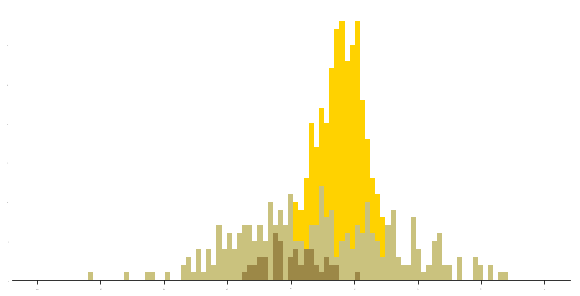

In [21]:
fig,ax = plt.subplots(figsize=(10, 5),facecolor='w')
plt.hist(one, bins=bins, label='x', color='#ffd200')
plt.hist(two, bins=bins, label='y', color = '#cac27e' )
plt.hist(three, bins=bins, label='y', color = '#9c8847' )

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
#ax.spines['bottom'].set_visible(False)

ax.tick_params(axis='x',labelsize=0)
ax.tick_params(axis='y',labelsize=0, width=0, size=0)

#ax.axvline(min(two),ls='--',color='darkred', linewidth = 1, alpha = 0.5)
#ax.axvline(min(one),ls='--',color='pink', linewidth = 1, alpha = 1)
#ax.axvline(min(three),ls='--',color='lightblue', linewidth = 1, alpha = 1)
plt.savefig('/Users/alliblk/Desktop/gitrepos/zika-usvi/palette_12_stata.png')
#plt.savefig('/Users/alliblk/Desktop/talk-images/epi_curve_clusters_transparent.pdf', transparent = True)

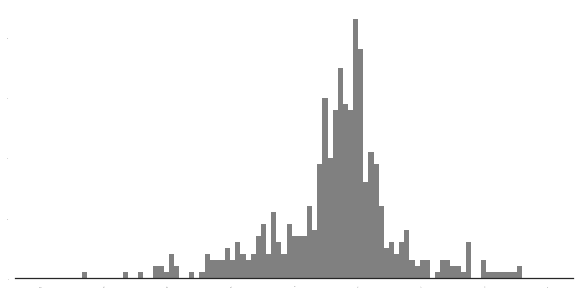

In [418]:
fig,ax = plt.subplots(figsize=(10, 5),facecolor='w')
plt.hist(one, bins=bins, alpha=1, label='x', color='gray')
plt.hist(two, bins=bins, alpha=1, label='y', color = 'gray')
plt.hist(three, bins=bins, alpha=1, label='y', color = 'gray')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
#ax.spines['bottom'].set_visible(False)

ax.tick_params(axis='x',labelsize=0)
ax.tick_params(axis='y',labelsize=0, width=0, size=0)

plt.savefig('/Users/alliblk/Desktop/talk-images/epi_curve_gray_transparent.pdf', transparent = True)

In [509]:
for origin,tree in sorted(within_country_trees['united_states_virgin_islands'],key=lambda x:(x[1].root.absoluteTime)):
    print origin,tree.root.absoluteTime

brazil 2014.4519018
brazil 2014.86843455
brazil 2014.90546726
dominican_republic 2015.60701659
dominican_republic 2015.79646009
dominican_republic 2016.08746793


In [323]:
#From EBOV
traitName='country.states'
# traitName='location'
linked_list.root.traits[traitName]='ancestor' ## give root node some trait value that's different from what the actual tree root has, so it registers as a switch
linked_list.root.y=0
linked_list.root.x= highestTip - highestTipinYearsFromRoot


#this dict stores subtrees where keys are countries that the virus jumped in to, and the value is a list with the parent country, and the subtree object:
#e.g.within_country_trees['united_states_virgin_islands'] would return multiple values, with the first being ('brazil', <baltic.tree instance at 0x112fd3cb0>)
#thus this would be an introduction from brazil, to the usvi, with the subtree saved as a baltic tree object.
within_country_trees2={}
posterior_support_threshold = 0.7

#this dictionary remembers how many leaves are in each country's subtree.
subtree_sizes2={country:[] for country in countries}
subtree_lengths2={country:[] for country in countries}
subtree_strings2 = {country:[] for country in countries}

with open('/Users/alliblk/Desktop/gitrepos/zika-usvi/beast/subtrees_0.8threshold.log', 'w') as file:
    file.write('origin_country\tdestination_country\tclade_TMRCA\tparent_TMRCA\tclade_size\tpersistence\ttree_string\n')

for k in sorted(linked_list.Objects,key=lambda x:x.height): ## iterate over branches, ordered by node.height, where root has the smallest height, and youngest tip has the greatest height
    kparent=k.parent
    
    kcountry=k.traits[traitName] #country that this node or leaf is in
    if k.parent.traits.has_key(traitName): #if the parent also has a designated country state
        kparentCountry = kparent.traits[traitName]
    else: ## if parent doesn't have a trait - dealing with root of tree
        kparentCountry = 'ancestor'
    
    if kcountry == kparentCountry and k.traits['country.states.prob']<0.85:
        print 'maybe found intro within tree'
        if isinstance(k,bt.node): ## and dealing with an internal node
            N_children=len(k.leaves)
        else: ## dealing with leaf...
            N_children=1
        
        within_country_subtree2 = linked_list.subtree(k,traitName=traitName) ## extract subtree during a within-trait traversal
        
        if within_country_subtree2: ## if you have successfully extracted a subtree, and have a new tree object
            within_country_subtree_leaves2=[x.name for x in within_country_subtree2.Objects if isinstance(x,bt.leaf)] ## get leaves in resulting subtree
            print '{} to {} jump (ancestor {} had {} child leaves in full tree, now has {} child leaves with same trait state.)'.format(kparentCountry,kcountry,k.index,N_children,len(within_country_subtree_leaves2))
            if within_country_trees2.has_key(kcountry): #if receiving country already in dictionary
                within_country_trees2[kcountry].append((kparentCountry,within_country_subtree2)) #add subtree to dict based on where the lineage jumped to
            else: #a receiving country isn't in the dict yet, need to make a new key and value pair.
                within_country_trees2[kcountry]=[(kparentCountry,within_country_subtree2)]
            
            subtree_sizes2[kcountry].append(len(within_country_subtree_leaves2)) ## remember subtree size

### working to here
            mostRecentSubtreeTip2 = max([k.absoluteTime for k in within_country_subtree2.Objects])

            #log the height of the subtree. Height is the total branch length from the midpoint of the branch that represents the country transition
            #to the most recently sampled tip in the subtree. Because some taxon names don't have complete y-m-d sampling dates, I'm using 
            #the k.absoluteTime trait that I made for all leaf and node objects earlier.
            subtree_lengths2[kcountry].append((k.length*0.5)+(mostRecentSubtreeTip2-k.absoluteTime))            
            subtree_strings2[kcountry].append(within_country_subtree2.toString()) ## remember subtree string, subtree object itself

            persistence=mostRecentSubtreeTip2-k.absoluteTime # this is amount of time that lineage stayed in a particular country
            ancestorTMRCA=k.parent.absoluteTime #sampling date for the ancestor to the subtree, which is in a different country
            cladeTMRCA=k.absoluteTime #sampling date of the first node of the subtree (in same country as rest of subtree)
            originCountry=kparentCountry #country that the subtree came from
            cladeSize=len(within_country_subtree_leaves2)

            with open('/Users/alliblk/Desktop/gitrepos/zika-usvi/beast/subtrees_0.8threshold', 'a') as file:
                output = '{}\t{}\t{}\t{}\t{}\t{}\t{}\n'.format(kparentCountry,kcountry,cladeTMRCA,ancestorTMRCA,cladeSize, persistence, within_country_subtree.toString())
                file.write(output)
   
    
    elif kcountry != kparentCountry: ## if the parent and the child are determined to be in different countries
        if isinstance(k,bt.node): ## and dealing with an internal node
            N_children=len(k.leaves)
        else: ## dealing with leaf...
            N_children=1
        
        within_country_subtree2 = linked_list.subtree(k,traitName=traitName) ## extract subtree during a within-trait traversal
        
        if within_country_subtree2: ## if you have successfully extracted a subtree, and have a new tree object
            within_country_subtree_leaves2=[x.name for x in within_country_subtree2.Objects if isinstance(x,bt.leaf)] ## get leaves in resulting subtree
            print '{} to {} jump (ancestor {} had {} child leaves in full tree, now has {} child leaves with same trait state.)'.format(kparentCountry,kcountry,k.index,N_children,len(within_country_subtree_leaves2))
            if within_country_trees2.has_key(kcountry): #if receiving country already in dictionary
                within_country_trees2[kcountry].append((kparentCountry,within_country_subtree2)) #add subtree to dict based on where the lineage jumped to
            else: #a receiving country isn't in the dict yet, need to make a new key and value pair.
                within_country_trees2[kcountry]=[(kparentCountry,within_country_subtree2)]
            
            subtree_sizes2[kcountry].append(len(within_country_subtree_leaves2)) ## remember subtree size

### working to here
            mostRecentSubtreeTip2 = max([k.absoluteTime for k in within_country_subtree2.Objects])

            #log the height of the subtree. Height is the total branch length from the midpoint of the branch that represents the country transition
            #to the most recently sampled tip in the subtree. Because some taxon names don't have complete y-m-d sampling dates, I'm using 
            #the k.absoluteTime trait that I made for all leaf and node objects earlier.
            subtree_lengths2[kcountry].append((k.length*0.5)+(mostRecentSubtreeTip2-k.absoluteTime))            
            subtree_strings2[kcountry].append(within_country_subtree2.toString()) ## remember subtree string, subtree object itself

            persistence=mostRecentSubtreeTip2-k.absoluteTime # this is amount of time that lineage stayed in a particular country
            ancestorTMRCA=k.parent.absoluteTime #sampling date for the ancestor to the subtree, which is in a different country
            cladeTMRCA=k.absoluteTime #sampling date of the first node of the subtree (in same country as rest of subtree)
            originCountry=kparentCountry #country that the subtree came from
            cladeSize=len(within_country_subtree_leaves2)

            with open('/Users/alliblk/Desktop/gitrepos/zika-usvi/beast/subtrees_0.8threshold', 'a') as file:
                output = '{}\t{}\t{}\t{}\t{}\t{}\t{}\n'.format(kparentCountry,kcountry,cladeTMRCA,ancestorTMRCA,cladeSize, persistence, within_country_subtree.toString())
                file.write(output)    #print>>output_subtrees,'%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s'%(kc,kloc,kpc,kploc,cladeTMRCA,ancestorTime,len(subtree_leaves),persistence,subtreeString)

            #print>>output_members,'%s'%(','.join(subtree_leaves))
        
        
        
print 'done!'

ancestor to brazil jump (ancestor 0 had 256 child leaves in full tree, now has 72 child leaves with same trait state.)
brazil to haiti jump (ancestor 789662 had 6 child leaves in full tree, now has 2 child leaves with same trait state.)
brazil to honduras jump (ancestor 597509 had 44 child leaves in full tree, now has 22 child leaves with same trait state.)
maybe found intro within tree
brazil to brazil jump (ancestor 412995 had 39 child leaves in full tree, now has 2 child leaves with same trait state.)
maybe found intro within tree
maybe found intro within tree
haiti to haiti jump (ancestor 793498 had 5 child leaves in full tree, now has 1 child leaves with same trait state.)
maybe found intro within tree
brazil to brazil jump (ancestor 412996 had 3 child leaves in full tree, now has 2 child leaves with same trait state.)
brazil to united_states_virgin_islands jump (ancestor 425058 had 36 child leaves in full tree, now has 22 child leaves with same trait state.)
haiti to brazil jump 

In [332]:
for origin,subtree in sorted(within_country_trees2['united_states_virgin_islands'],key=lambda x: (x[1].root.absoluteTime,len(x[1].leaves)),reverse=True):
    print origin
    print subtree.Objects[0].traits['country.states']
    print subtree.root.numChildren

dominican_republic
united_states_virgin_islands
1
dominican_republic
united_states_virgin_islands
1
united_states_virgin_islands
united_states_virgin_islands
1
dominican_republic
united_states_virgin_islands
5
united_states_virgin_islands
united_states_virgin_islands
19
united_states_virgin_islands
united_states_virgin_islands
1
united_states_virgin_islands
united_states_virgin_islands
19
united_states_virgin_islands
united_states_virgin_islands
1
united_states_virgin_islands
united_states_virgin_islands
1
united_states_virgin_islands
united_states_virgin_islands
1
united_states_virgin_islands
united_states_virgin_islands
21
brazil
united_states_virgin_islands
1
brazil
united_states_virgin_islands
22
brazil
united_states_virgin_islands
1


(2014, 2017)

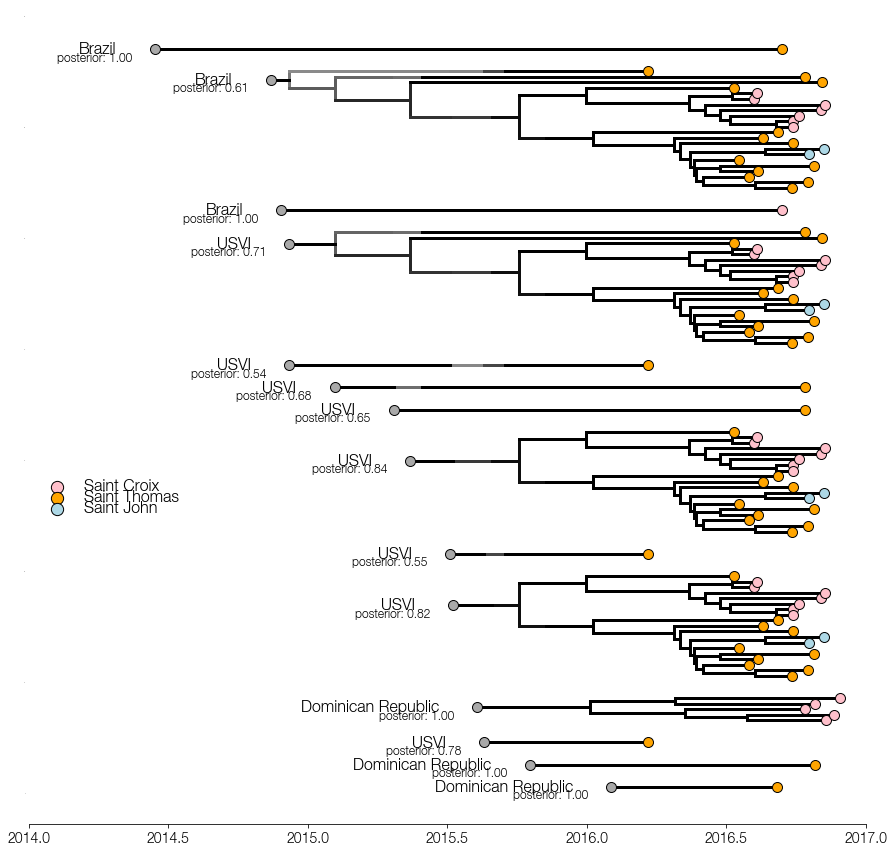

In [558]:
#print within_country_trees['united_states_virgin_islands']
#print subtree_sizes['united_states_virgin_islands']
usvi_island_colors = {'saint_croix': 'pink', 'saint_thomas': 'orange' ,'saint_john': 'lightblue'}
labeling_dict = {'dominican_republic':'Dominican Republic', 'brazil': 'Brazil', 'united_states_virgin_islands': 'USVI'}

colorbarTextSize=30 ## add colourbars
colorbarTickLabelSize=24
colorbarWidth=0.02
colorbarHeight=0.4
colorbarIncrement=0.08

#ax2 = fig.add_axes([colorbarIncrement*4, 0.13, colorbarHeight, colorbarWidth]) ## add dummy axes
#mpl.colorbar.ColorbarBase(ax2, cmap=mpl.cm.Greys,orientation='horizontal')
#color_map = [mpl.cm.Greys(x) for x in np.linspace(0.0,1.0,10)])

#####

fig,ax = plt.subplots(figsize=(15,15),facecolor='w')
branchWidth=3 ## default branch width
tipSize = 100

cumulative_y = 0
#for origin,subtree in within_country_trees['united_states_virgin_islands']: #iterating over introductions to the USVI
#for origin,subtree in sorted(within_country_trees['united_states_virgin_islands'],key=lambda x: (len(x[1].leaves), x[1].root.absoluteTime),reverse=True):
for origin,subtree in sorted(within_country_trees2['united_states_virgin_islands'],key=lambda x: (x[1].root.absoluteTime,len(x[1].leaves)),reverse=True):
    for k in subtree.Objects:
        x = k.absoluteTime
        y = k.y
        if k.parent.x == None:
            xp = x
        else:  
            xp = k.parent.absoluteTime

        #branch_color='lightgrey'
        branch_color = mpl.cm.Greys(k.traits['country.states.prob'])
        
        if isinstance(k,bt.leaf): ## leaves have circles at tips
            island = usvi_specific_island[k.name.split('|')[0]]
            color = usvi_island_colors[island]
            ax.scatter(x,y+cumulative_y,s=tipSize,facecolor=color,edgecolor='black',zorder=100) ## plot tip circle
            #ax.scatter(x,y+cumulative_y,s=tipSize+50,facecolor='k',edgecolor='none',zorder=99)

        elif isinstance(k,bt.node): ## nodes have vertical lines
            child1_y=k.children[0].y
            child2_y=k.children[-1].y
            ax.plot([x,x],[child1_y+cumulative_y,child2_y+cumulative_y],color=branch_color,lw=branchWidth,zorder=98) ## plot vertical bar 
        ax.plot([x,xp],[y+cumulative_y,y+cumulative_y],color=branch_color,lw=branchWidth,zorder=98) ## plot branch
    
    min_node_x = min(k.absoluteTime for k in subtree.Objects)        
    origin_color='darkgrey'
                  
    if subtree.Objects[0].absoluteTime==None:
        origin_prob = subtree.Objects[0].traits['country.states.prob']
        origin_x=subtree.Objects[0].absoluteTime #sending country has same x coord as root in receiving country.
        origin_y=subtree.Objects[0].y+cumulative_y #and same for the y coordinates
    else:
        origin_prob = subtree.Objects[0].traits['country.states.prob']
        origin_x=subtree.Objects[0].parent.absoluteTime
        origin_y=subtree.Objects[0].y+cumulative_y

    if origin!='ancestor': ## add text if not dealing with the very first introduction into the americas
        ax.text(origin_x-50/365.0,origin_y,'{}'.format(labeling_dict[origin]),ha='right',va='center', size=16) #label origin country
        ax.text(origin_x-30/365.0,origin_y-1.5,'posterior: {0:.2f}'.format(origin_prob),ha='right',va='center', size=12)
        ax.scatter(origin_x,origin_y,100,facecolor=origin_color,edgecolor='black',lw=1,zorder=200) ## circle at the base of the subtree to indicate origin
        ax.plot([min_node_x,origin_x],[origin_y,origin_y],color=branch_color,lw=branchWidth,zorder=98)
        
    cumulative_y+=max([x.y for x in subtree.Objects])+3 ## increment y position

#Remove lines from sides of plot that I don't like
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
#ax.spines['bottom'].set_visible(False)

#make legend
ax.scatter(2014.1,55,s=150,facecolor=usvi_island_colors['saint_croix'],edgecolor='black',zorder=10) ## plot circle for node
ax.scatter(2014.1,53,s=150,facecolor=usvi_island_colors['saint_thomas'],edgecolor='black',zorder=10) ## plot black circle underneath
ax.scatter(2014.1,51,s=150,facecolor=usvi_island_colors['saint_john'],edgecolor='black',zorder=10) ## plot circle for node

ax.text(2014.2,54.5, 'Saint Croix', size=16)
ax.text(2014.2,52.5, 'Saint Thomas', size=16)
ax.text(2014.2,50.5, 'Saint John', size=16)

ax.tick_params(axis='y',labelsize=0,size=0)
ax.tick_params(axis='top',labelsize=0,size=0)

ax.set_xlim(2014,2017)

NameError: name 'within_country_trees2' is not defined